# Import Libraries

In [ ]:
%pip install imbalanced-learn==0.12.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 5.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, contingency
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import f1_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import shap
import pickle

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Global Variables

In [3]:
train = pd.read_csv('/kaggle/input/neurontara-dataset-2025/train.csv') # change to local directory if needed
test = pd.read_csv('/kaggle/input/neurontara-dataset-2025/test.csv').drop('id',axis=1) # change to local directory if needed
submission = pd.read_csv('/kaggle/input/neurontara-dataset-2025/sample_submission.csv') # change to local directory if needed

X = train.drop('Data Quality', axis=1)
y = train['Data Quality']

seed = 20
np.random.seed(seed)

target_map = {
    'Fair': 3,
    'Good': 2,
    'Pending review': 1,
    'Unknown': 0
}

# Dataset Understanding

In [4]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13998 entries, 0 to 13997
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Latitude              10388 non-null  float64
 1   Longitude             6925 non-null   float64
 2   Station Code          8638 non-null   object 
 3   Depth                 9553 non-null   float64
 4   Parameter Code        12301 non-null  object 
 5   Analysis Method Code  2401 non-null   object 
 6   Value Flags           2170 non-null   object 
 7   Data Quality          13998 non-null  object 
 8   Dataset_Source        7786 non-null   object 
 9   temperature_avg       9481 non-null   float64
 10  rainfall_mm           8824 non-null   float64
 11  humidity_pct          13149 non-null  float64
 12  pressure_hPa          7184 non-null   float64
 13  drought_index         8019 non-null   float64
 14  extreme_precip_days   11975 non-null  float64
 15  urban_pct          

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Latitude              4452 non-null   float64
 1   Longitude             2990 non-null   float64
 2   Station Code          3773 non-null   object 
 3   Depth                 4058 non-null   float64
 4   Parameter Code        5294 non-null   object 
 5   Analysis Method Code  1041 non-null   object 
 6   Value Flags           981 non-null    object 
 7   Dataset_Source        3418 non-null   object 
 8   temperature_avg       4108 non-null   float64
 9   rainfall_mm           3803 non-null   float64
 10  humidity_pct          5664 non-null   float64
 11  pressure_hPa          3086 non-null   float64
 12  drought_index         3488 non-null   float64
 13  extreme_precip_days   5113 non-null   float64
 14  urban_pct             5253 non-null   float64
 15  forest_pct           

In [7]:
print(f"Train Shape \t: {train.shape}")
print(f"Test Shape \t: {test.shape}")

Train Shape 	: (13998, 42)
Test Shape 	: (6000, 41)


In [8]:
train.head()

,Latitude,Longitude,Station Code,Depth,Parameter Code,Analysis Method Code,Value Flags,Data Quality,Dataset_Source,temperature_avg,rainfall_mm,humidity_pct,pressure_hPa,drought_index,extreme_precip_days,urban_pct,forest_pct,agriculture_pct,water_pct,wetland_pct,grassland_pct,barren_pct,frag_index,soil_perm,ind_count,hg_impact,pb_impact,ind_risk_score,param_category,country_code,time_season,value_with_unit,sampling_method,is_referenced_method,water_body_type,analytical_program,pollution_risk,testing_laboratory,validated_results,sampling_weather,regulatory_framework,land_use_impact
0,50.90280,NaN,CAN00062,NaN,OH,VMV_351,NaN,Fair,NaN,NaN,107.991295,95.000000,1005.214660,1.794697,NaN,5.951478,31.263524,24.569630,9.797753,7.869977,NaN,4.582338,0.689209,0.580086,1.0,0.175103,0.260952,11.968313,Other,NaN,2016-07-06 12:00:00 - Summer,0.0 mg/l,NaN,False,Wetland,Provincial Monitoring,Medium,National Water Research Center,False,Snowy,NaN,Agricultural Dominant
1,NaN,NaN,NaN,0.3,NaN,NaN,NaN,Fair,carbon,NaN,76.765242,85.981444,1010.711472,1.895847,1.0,7.383620,27.776921,27.307877,NaN,10.232954,14.966313,NaN,NaN,0.596833,0.0,0.000000,NaN,0.000000,NaN,CHE,NaN,NaN,Composite Sample,True,NaN,NaN,Low,NaN,True,NaN,International Water Quality Standards,Agricultural Dominant
2,46.27117,11.42484,ITA00304,0.0,NaN,APAT3200_2003,<,Fair,mercury,-5.702201,NaN,85.398487,NaN,1.526776,0.0,9.247551,28.228460,26.985046,4.872352,10.266351,14.167929,6.232312,0.742477,NaN,NaN,0.230421,0.145780,2.603596,Heavy Metal,ITA,2011-07-05 00:00:00 - Summer,0.1 µg/l,Grab Sample,NaN,NaN,NaN,NaN,International Water Quality Lab,True,NaN,International Water Quality Standards,NaN
3,49.45860,-120.50400,CAN00328,0.3,Cs-Tot,VMV_3528,NaN,Fair,caesium,6.250698,101.644133,82.476995,NaN,-1.132845,2.0,5.333536,26.070002,26.362196,NaN,5.620951,16.146108,7.907507,0.672276,0.573120,2.0,0.291064,NaN,2.256460,NaN,NaN,2011-05-10 10:05:00 - Spring,NaN,Composite Sample,False,Reservoir,NaN,NaN,Canadian Analytical Services,True,Rainy,Fisheries Act,Agricultural Dominant
4,49.52790,-115.54920,CAN00204,0.3,Li-Tot,VMV_1919,NaN,Good,lithium,-9.855316,NaN,80.188658,NaN,1.638208,0.0,6.655140,NaN,24.677142,10.276568,7.910548,NaN,6.495076,NaN,0.573831,1.0,0.736880,1.816768,3.178037,Other,NaN,2005-08-02 10:00:00 - Summer,1.7 µg/l,Manual Sample,False,River,NaN,Medium,National Water Research Center,True,NaN,Canadian Environmental Protection Act,NaN


In [9]:
test.head()

,Latitude,Longitude,Station Code,Depth,Parameter Code,Analysis Method Code,Value Flags,Dataset_Source,temperature_avg,rainfall_mm,humidity_pct,pressure_hPa,drought_index,extreme_precip_days,urban_pct,forest_pct,agriculture_pct,water_pct,wetland_pct,grassland_pct,barren_pct,frag_index,soil_perm,ind_count,hg_impact,pb_impact,ind_risk_score,param_category,country_code,time_season,value_with_unit,sampling_method,is_referenced_method,water_body_type,analytical_program,pollution_risk,testing_laboratory,validated_results,sampling_weather,regulatory_framework,land_use_impact
0,NaN,NaN,NaN,NaN,Pb-Dis,NaN,NaN,NaN,7.638085,142.897101,95.000000,1004.880244,-0.759573,4.0,7.157315,27.631679,NaN,5.648436,NaN,13.679239,5.620566,0.724813,0.582672,0.0,0.000000,0.000000,0.000000,Heavy Metal,ITA,2018-05-08 12:00:00 - Spring,0.0003 mg/l,Grab Sample,True,NaN,International Water Assessment,High,International Water Quality Lab,True,Clear,International Water Quality Standards,Mixed Land Use
1,NaN,NaN,ROU00035,0.3,H-T,NaN,NaN,NaN,-1.347859,51.029480,71.291741,NaN,0.249945,0.0,NaN,28.105486,NaN,9.103573,5.702474,10.486583,5.837077,0.818458,0.540570,0.0,0.000000,0.000000,0.000000,NaN,NaN,2012-11-08 12:00:00 - Fall,295.17 mg/l,Automated Sample,False,River,International Water Assessment,Low,International Water Quality Lab,NaN,Cloudy,International Water Quality Standards,Urban Dominant
2,21.967530,NaN,NaN,NaN,Pb-Tot,NaN,<,NaN,16.907207,82.401543,71.447583,NaN,-1.842977,4.0,NaN,34.429576,21.705035,9.465267,7.246239,9.736014,4.698620,0.775821,0.550564,0.0,0.000000,0.000000,0.000000,Heavy Metal,NaN,2017-05-23 12:00:00 - Spring,0.00154 mg/l,Manual Sample,False,NaN,NaN,Medium,International Water Quality Lab,True,NaN,International Water Quality Standards,Urban Dominant
3,NaN,83.274722,IND02411,NaN,EC,NaN,NaN,NaN,NaN,79.396807,65.556748,1005.815597,-0.624389,NaN,11.328300,38.399268,NaN,3.068677,8.599693,8.309711,3.399760,0.787399,0.594455,1.0,0.047625,0.015881,2.675262,Other,IND,2006-01-05 00:00:00 - Winter,580.0 µS/cm,Manual Sample,True,NaN,NaN,Low,International Water Quality Lab,True,Clear,International Water Quality Standards,Agricultural Dominant
4,19.535278,74.833611,IND02093,0.3,H-T,NaN,NaN,NaN,6.339215,52.887421,75.978720,1010.051033,NaN,0.0,6.331446,NaN,23.194579,NaN,7.503180,11.095771,4.091664,0.690486,0.624313,0.0,0.000000,NaN,0.000000,Other,IND,2016-10-01 00:00:00 - Fall,NaN,Automated Sample,NaN,NaN,NaN,Low,International Water Quality Lab,True,NaN,International Water Quality Standards,Urban Dominant


In [10]:
train.describe()

,Latitude,Longitude,Depth,temperature_avg,rainfall_mm,humidity_pct,pressure_hPa,drought_index,extreme_precip_days,urban_pct,forest_pct,agriculture_pct,water_pct,wetland_pct,grassland_pct,barren_pct,frag_index,soil_perm,ind_count,hg_impact,pb_impact,ind_risk_score
count,10388.000000,6925.000000,9553.000000,9481.000000,8824.000000,13149.000000,7184.000000,8019.000000,11975.000000,12109.000000,12167.000000,11378.000000,9981.000000,10580.000000,11424.000000,9440.000000,12429.000000,11456.000000,11024.000000,10463.000000,8331.000000,12045.000000
mean,35.436061,-27.693376,0.456213,6.824907,80.873508,80.595012,1008.435708,0.006299,1.272735,9.185385,33.607311,24.931137,6.608126,8.297825,12.331256,5.015210,0.737440,0.584229,0.430062,0.166358,0.174060,1.379598
std,16.219775,75.700544,5.159160,10.630105,28.561500,8.839679,3.688106,1.158943,1.355884,3.373840,4.201638,2.935470,2.659858,1.620872,3.779209,1.431305,0.049427,0.023127,0.894309,1.460679,1.725642,4.047634
min,-51.688333,-162.882936,0.000000,-22.621346,15.497462,49.146679,995.417479,-1.998474,0.000000,0.257167,22.672102,14.773091,1.826344,2.767104,2.864197,0.782129,0.592426,0.518350,0.000000,0.000000,0.000000,0.000000
25%,21.394603,-100.809745,0.300000,-1.068542,57.891712,74.117278,1005.858214,-1.001138,0.000000,6.513480,30.214947,22.909077,4.500750,7.406341,9.045556,4.129750,0.699000,0.565790,0.000000,0.000000,0.000000,0.000000
50%,36.339265,-6.649400,0.300000,7.007714,78.730045,80.307203,1008.512444,0.014264,1.000000,9.331719,33.600484,24.905093,6.134553,8.363030,12.180642,5.044905,0.743271,0.582249,0.000000,0.000000,0.000000,0.000000
75%,49.148500,21.982860,0.300000,14.660102,101.413967,87.432189,1010.999508,1.021632,2.000000,11.976079,36.751078,26.901411,8.215836,9.257593,15.631952,6.044761,0.774717,0.603042,1.000000,0.020725,0.024444,0.351765
max,81.842880,96.170556,300.000000,32.337238,201.615502,95.000000,1022.112516,1.999635,9.000000,17.700829,47.457342,37.626821,14.306060,13.365626,22.773705,8.963669,0.873797,0.650025,7.000000,62.146841,100.000000,47.513133


In [11]:
test.describe()

,Latitude,Longitude,Depth,temperature_avg,rainfall_mm,humidity_pct,pressure_hPa,drought_index,extreme_precip_days,urban_pct,forest_pct,agriculture_pct,water_pct,wetland_pct,grassland_pct,barren_pct,frag_index,soil_perm,ind_count,hg_impact,pb_impact,ind_risk_score
count,4452.000000,2990.000000,4058.000000,4108.000000,3803.000000,5664.000000,3086.000000,3488.000000,5113.000000,5253.000000,5181.000000,4883.000000,4295.000000,4531.000000,4954.000000,4052.000000,5314.000000,4914.000000,4678.000000,4431.000000,3602.000000,5157.000000
mean,35.309142,-29.913406,0.481906,7.131712,80.914201,80.469267,1008.491797,0.037096,1.282222,9.141972,33.714608,24.998396,6.632132,8.271665,12.238998,5.018334,0.736685,0.584458,0.446345,0.161132,0.164363,1.425774
std,16.763667,75.174373,4.906778,10.692177,28.539677,8.803072,3.625670,1.171187,1.359468,3.401920,4.193818,2.941649,2.654313,1.638763,3.781134,1.443167,0.050181,0.023074,0.911058,1.337050,0.896401,4.220210
min,-51.688333,-162.882936,0.000000,-23.192777,18.789209,51.171390,996.543741,-1.998976,0.000000,0.236831,22.672102,14.773091,1.826344,2.767104,3.515850,0.531006,0.607618,0.517722,0.000000,0.000000,0.000000,0.000000
25%,21.442547,-100.850917,0.300000,-0.544168,57.633513,74.100536,1006.027270,-0.956207,0.000000,6.379096,30.299249,23.066229,4.512185,7.349709,8.966606,4.130935,0.696523,0.566042,0.000000,0.000000,0.000000,0.000000
50%,35.500341,-9.593605,0.300000,7.173896,78.712494,80.272504,1008.534329,0.030917,1.000000,9.299119,33.727992,25.060670,6.134553,8.350358,12.127559,5.061401,0.742426,0.582481,0.000000,0.000000,0.000000,0.000000
75%,49.177675,21.060575,0.300000,14.800591,101.773471,87.048573,1010.900227,1.064491,2.000000,12.034308,36.805457,26.931245,8.222456,9.221092,15.590447,6.062933,0.776233,0.603511,1.000000,0.028569,0.045448,0.488578
max,81.842880,96.209444,270.000000,33.692087,193.978101,95.000000,1020.331861,1.999635,9.000000,17.405448,47.457342,37.626821,14.306060,13.317758,21.746679,8.934847,0.873797,0.652929,7.000000,62.146841,29.495013,100.000000


# EDA

In [12]:
numerical = train.select_dtypes(exclude='object').columns.tolist()
categorical = train.select_dtypes(include='object').columns.tolist()

## Categorical Unique Values & Counts

In [13]:
for col in categorical:
    print(f"==== {col} ====")
    print(train[col].unique())
    print()

==== Station Code ====
['CAN00062' nan 'ITA00304' ... 'MEX01080' 'MEX02512' 'MEX03985']

==== Parameter Code ====
['OH' nan 'Cs-Tot' 'Li-Tot' 'F-Dis' 'O2-Dis-Sat' 'Cr-Tot' 'Cl-Dis'
 'Fe-Ext' 'Ca-Dis' 'HCO3' 'Alk-Phen' 'FECALCOLI' 'H-T' 'DOC' 'Fe-Tot'
 'O2-Dis' '11DCE' 'Cd-Tot' 'Cu-Tot' 'La-Dis' 'Mg-Dis' 'Ni-Tot' 'Alk-Tot'
 'Hg-Tot' 'Cl-Tot' 'ECOLI' 'Mn-Dis' 'La-Tot' 'Cd-Dis' 'Ba-Tot' 'Cu-Dis'
 'Sb-Tot' 'Fe-Dis' 'As-Tot' 'CN-Tot' 'Ce-Dis' 'EC' 'Q-Inst' 'trans-DCE'
 'Pb-Dis' 'Mo-Dis' 'DCE' 'TCMA' 'Mn-Tot' 'Be-Dis' 'Ca-Tot' 'TOC' 'Be-Tot'
 'TOTCOLI' 'Al-Tot' 'ENTCOCC' 'B-Dis' 'METHYLBROMIDE' 'Hg-Dis' 'BDCMA'
 'Mo-Tot' 'Pb-Tot' 'Al-Dis' 'Mg-Tot' 'Ba-Dis' 'H-Ca' 'Co-Ext' 'Co-Dis'
 'Bi-Tot' 'CO3' 'CHLORODIBROMOMETHANE' 'Ni-Dis' 'CHLOROBROMOMETHANE'
 'Mg-Ext' 'Cr-Dis' 'As-Dis' 'Nb-Tot' 'Co-Tot' 'B-Tot' 'Mo-Ext' 'Ca-Ext'
 'Be-Ext' 'CO2' 'Al-Ext' 'Cs-Ext' 'BROMOFORM' 'POC' 'H-NC' '1122TTCETA'
 'La-Ext' 'Ba-Ext' 'Ce-Tot' 'As-Sus' 'FECALSTREP' 'DCB' 'Ga-Dis' 'Ga-Tot'
 'Pb-Ext' 'F-Tot' 'Nb-Dis' 'T

In [14]:
for col in train.select_dtypes(include='object').columns:
    print(train[col].value_counts())
    print()

Station Code
CAN00023    45
CAN00146    31
CAN00030    29
CAN00252    27
CAN00328    26
            ..
MEX00677     1
MEX02114     1
GRC01048     1
CHE00080     1
MEX03985     1
Name: count, Length: 3970, dtype: int64

Parameter Code
EC            804
O2-Dis        614
O2-Dis-Sat    479
H-T           470
Cd-Tot        395
             ... 
Cs-Ext          2
TIC             2
Ni-Sus          2
CN-Free         2
Br2-Dis         1
Name: count, Length: 121, dtype: int64

Analysis Method Code
VMV_3528           501
VMV_1919           368
VMV_3529           173
APHA3120_B_2005     76
VMV_2841            75
                  ... 
MFT                  1
ISO10301_1997        1
EN1233_1996          1
ISTISAN147_2000      1
VMV_3738             1
Name: count, Length: 136, dtype: int64

Value Flags
<    2040
>     130
Name: count, dtype: int64

Data Quality
Fair              10133
Unknown            3590
Good                251
Pending review       24
Name: count, dtype: int64

Dataset_Source
diss

## Categorical Null Values

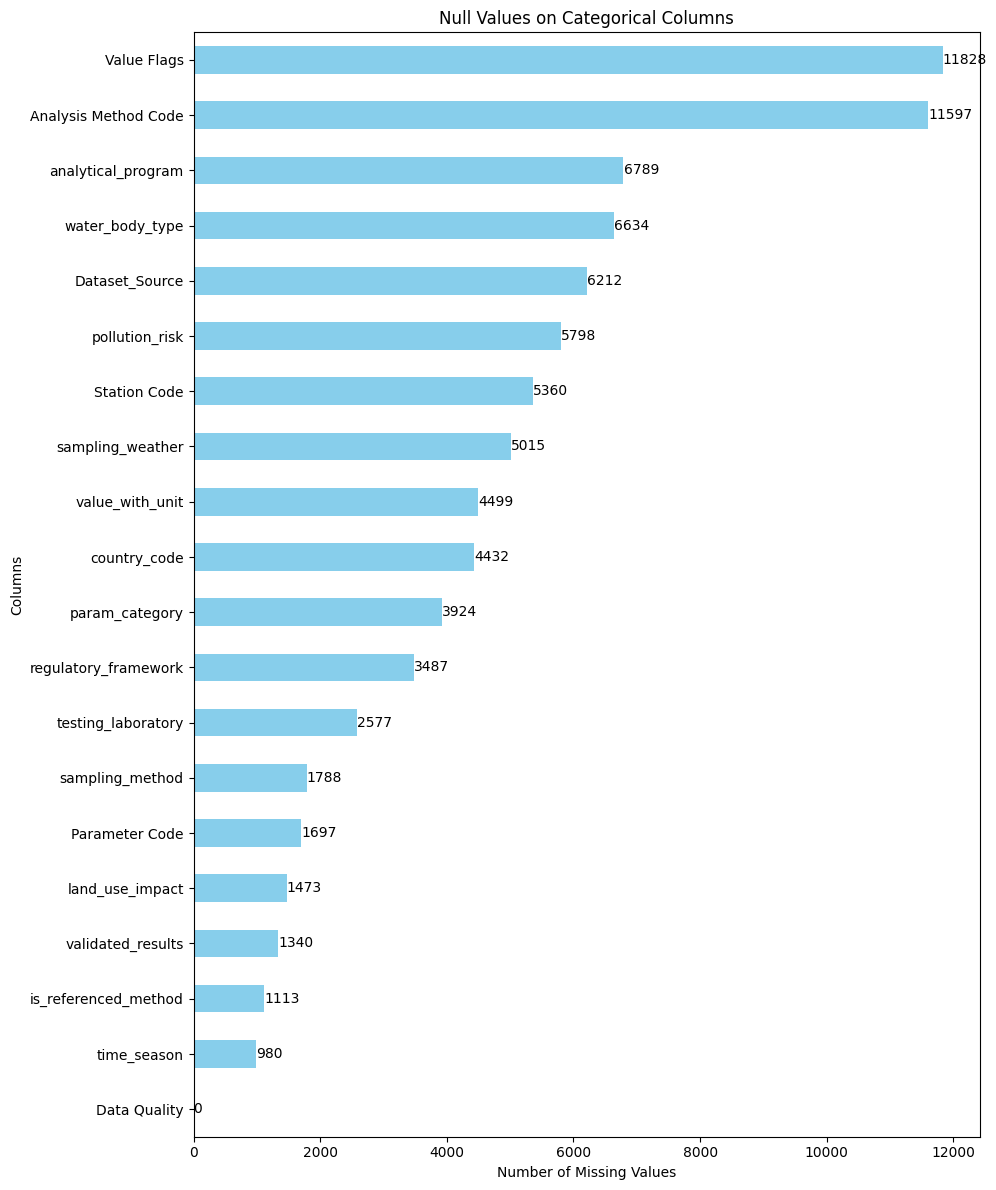

In [15]:
def plot_null(null_dtypes, title):
    plt.figure(figsize=(10, 12))
    ax = null_dtypes.plot(kind='barh', color='skyblue')
    plt.title(title)
    plt.xlabel('Number of Missing Values')
    plt.ylabel('Columns')
    plt.tight_layout()
    
    for i, (value, name) in enumerate(zip(null_dtypes.values, null_dtypes.index)):
        ax.text(value + 1, i, str(value), va='center')
    
    plt.show()
    
null_categorical = train[categorical].isnull().sum().sort_values(ascending=True)

plot_null(null_categorical, "Null Values on Categorical Columns")

## Numerical Null Values

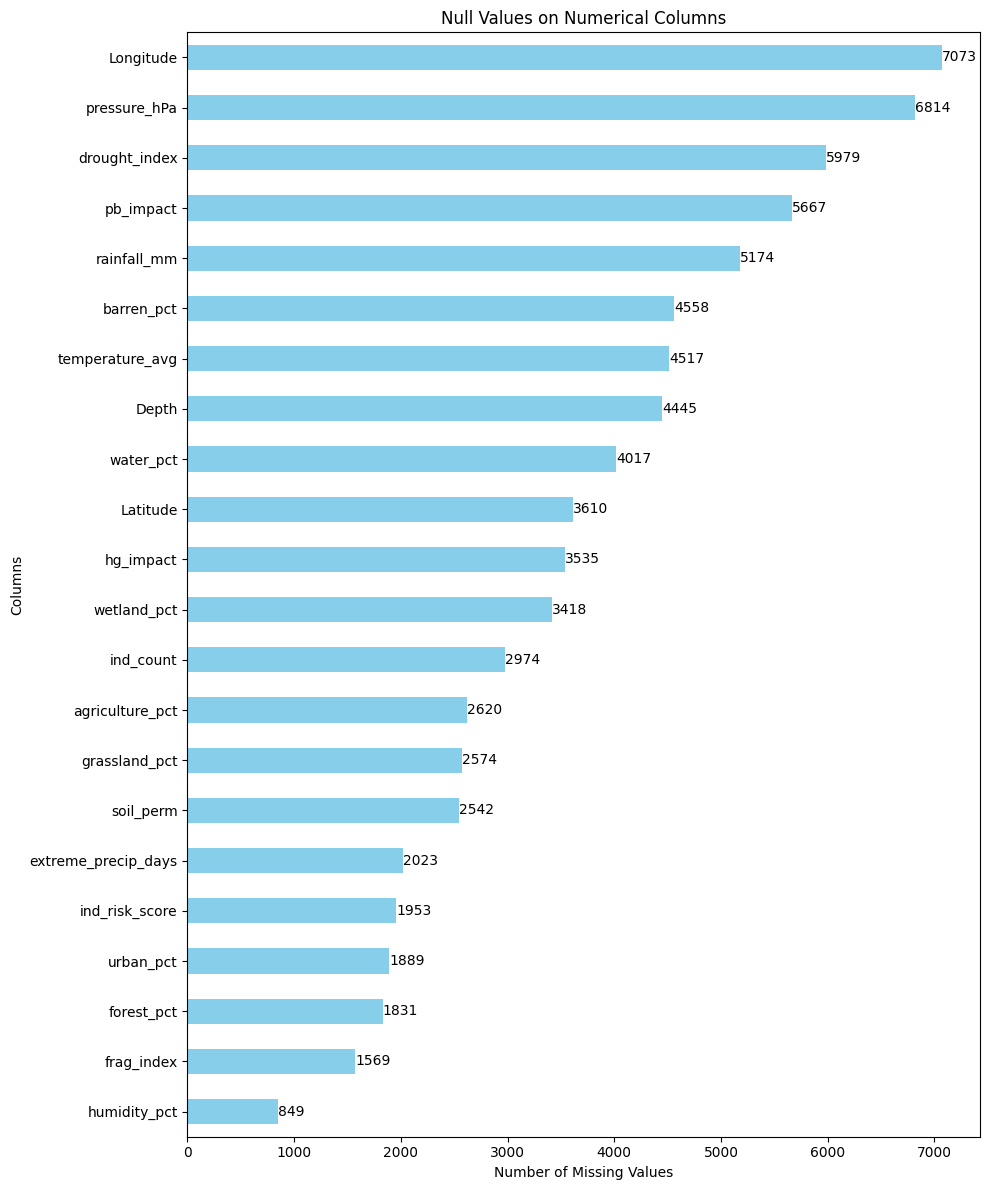

In [16]:
null_numerical = train[numerical].isnull().sum().sort_values(ascending=True)

plot_null(null_numerical, "Null Values on Numerical Columns")

## Violin Plot of Numerical Columns

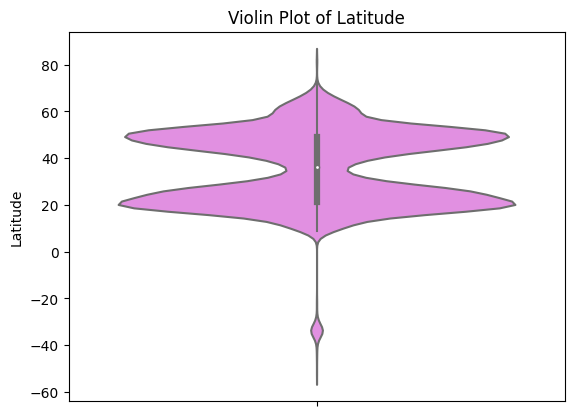

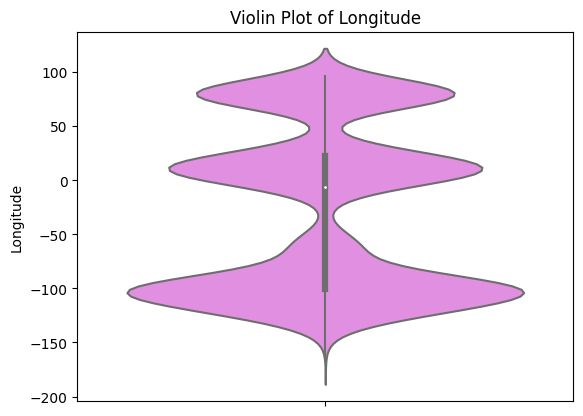

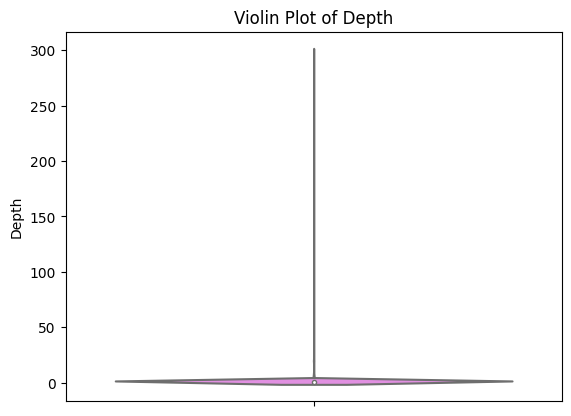

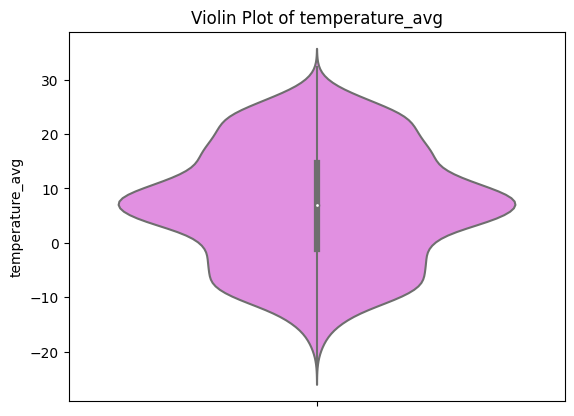

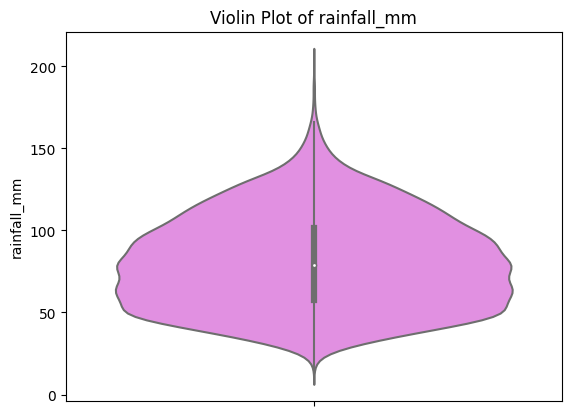

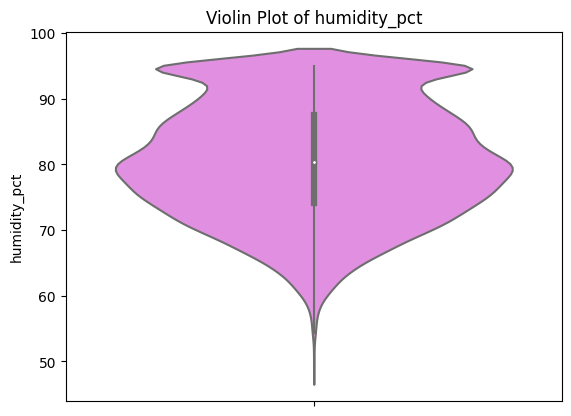

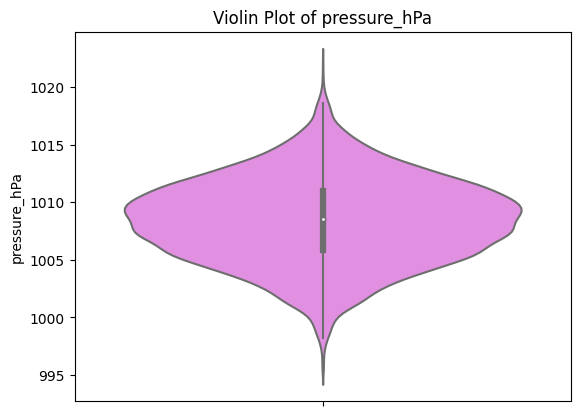

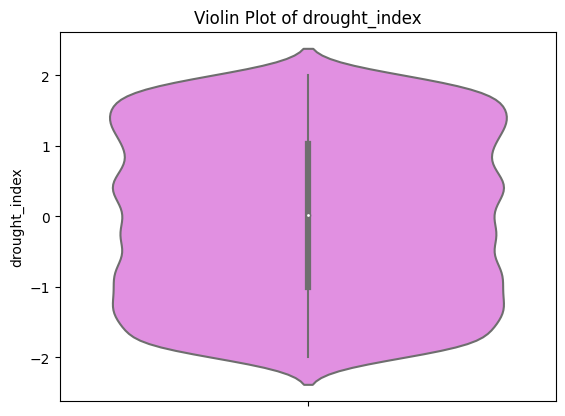

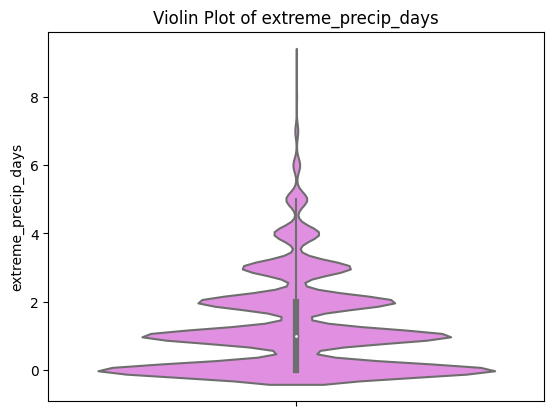

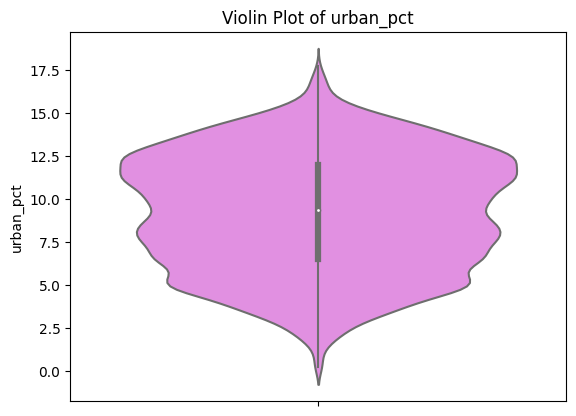

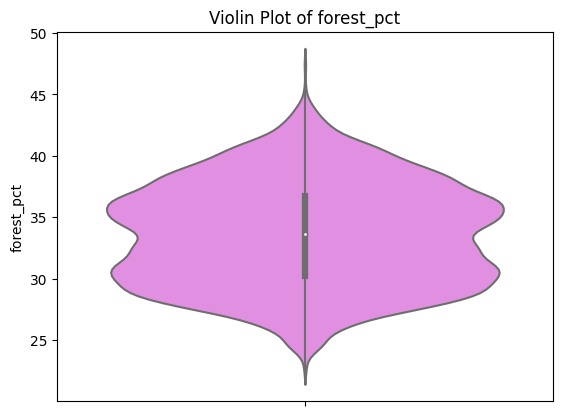

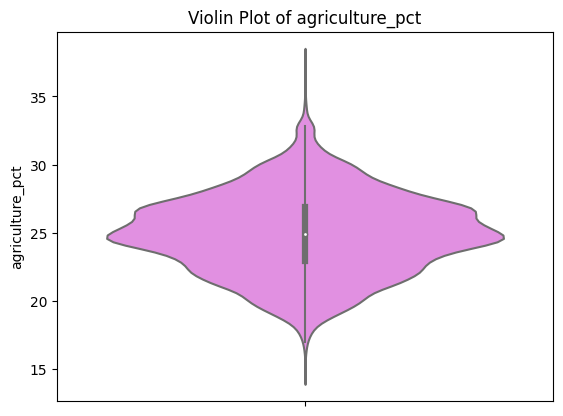

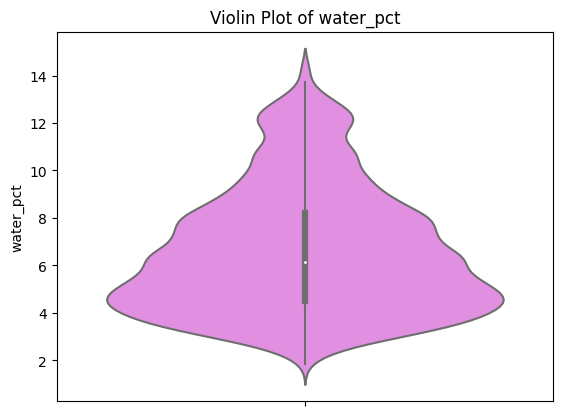

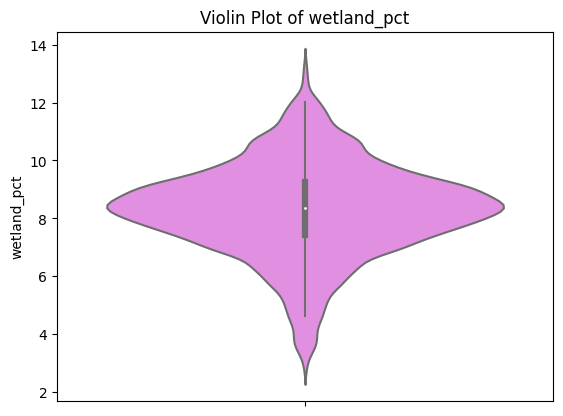

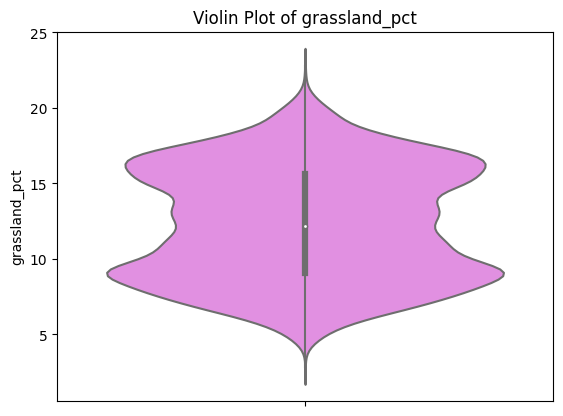

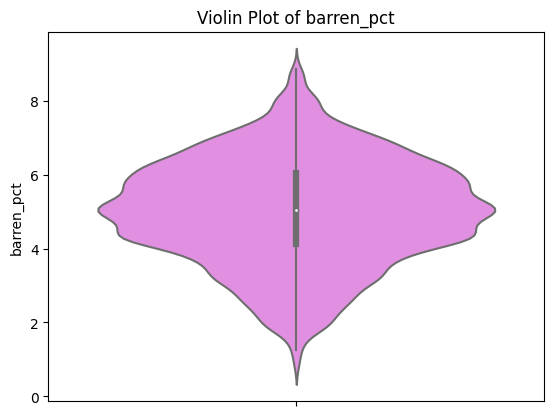

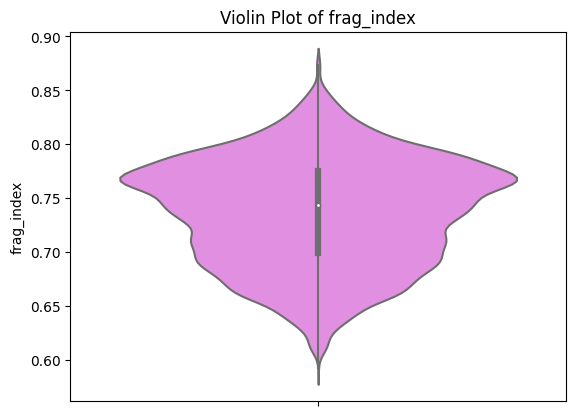

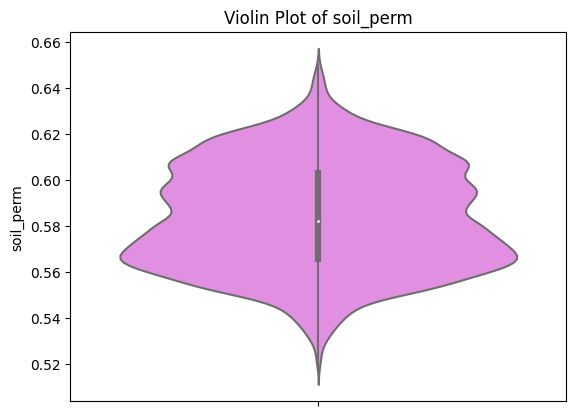

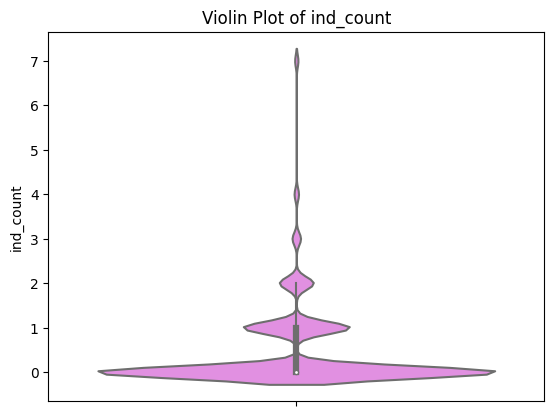

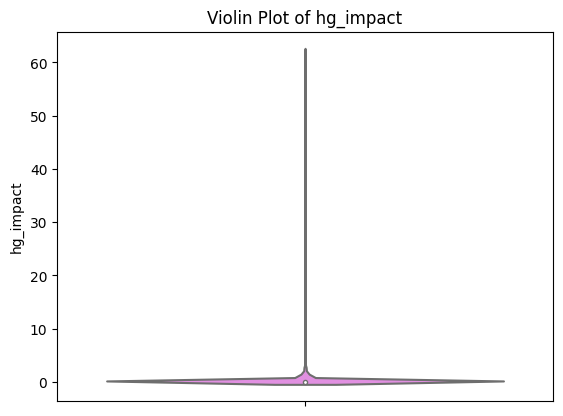

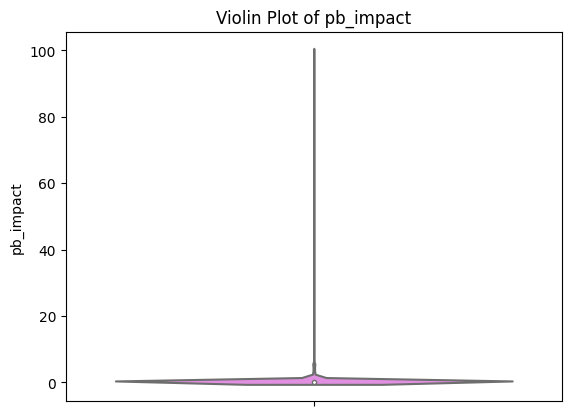

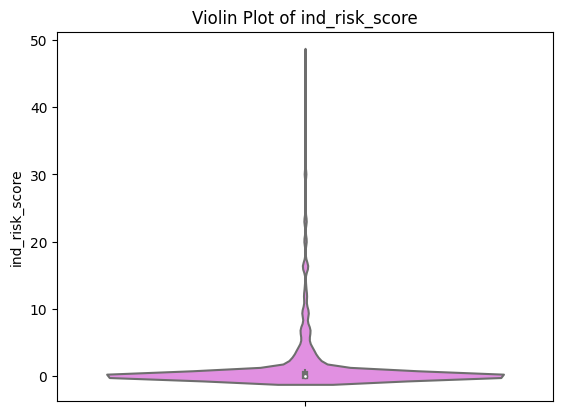

In [17]:
for col in numerical:
    sns.violinplot(y=train[col], color='violet')
    plt.title(f'Violin Plot of {col}')
    plt.show()

## Boxplot of Numerical Columns

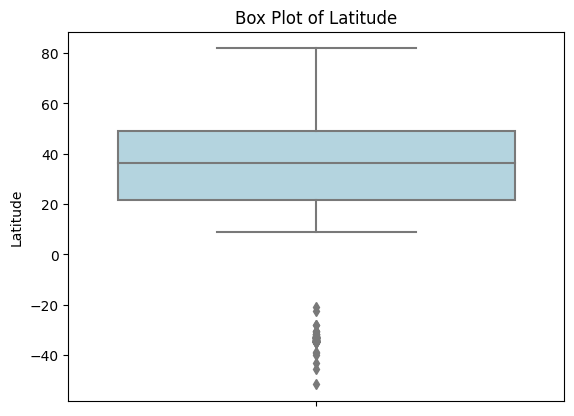

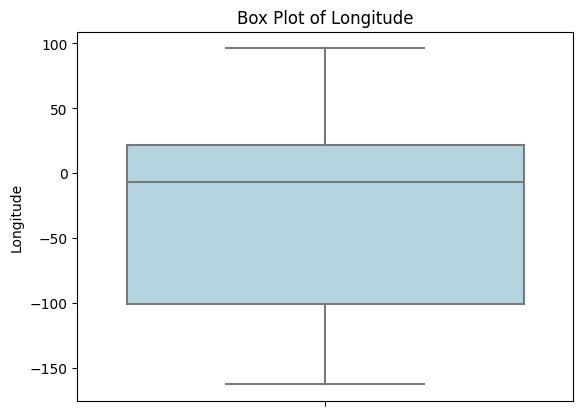

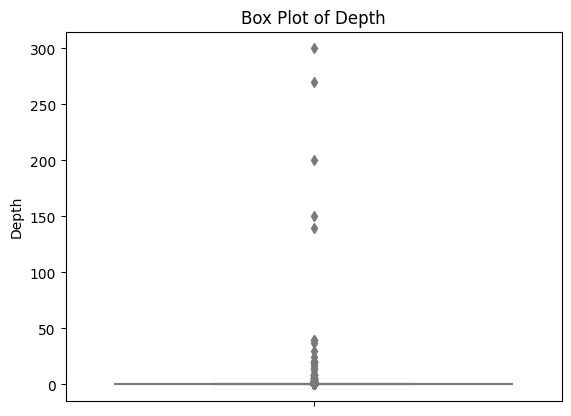

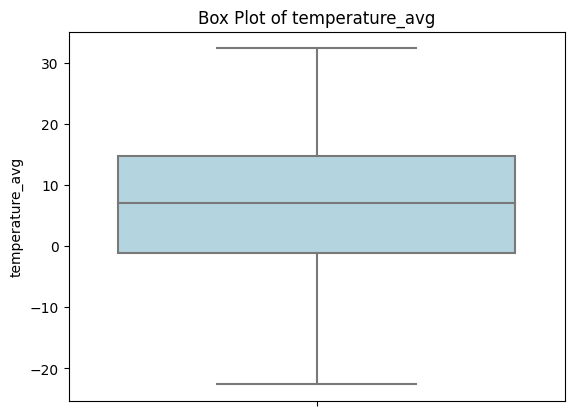

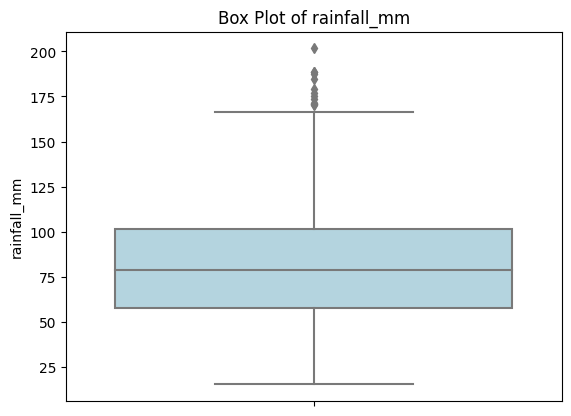

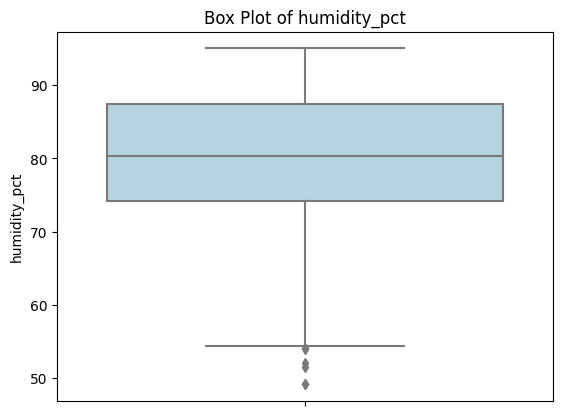

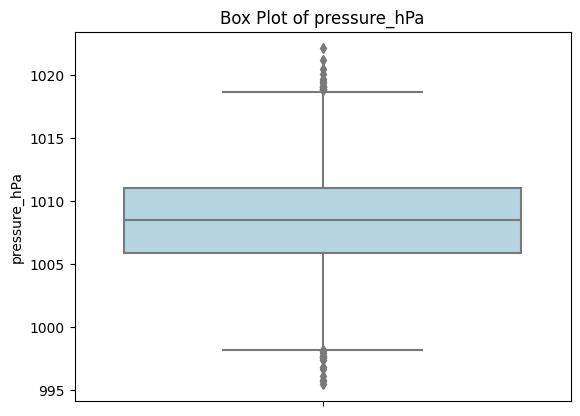

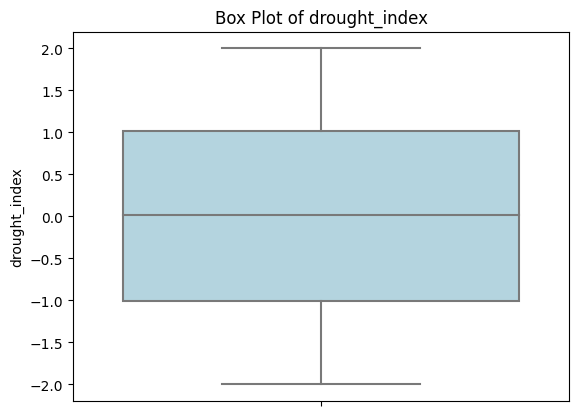

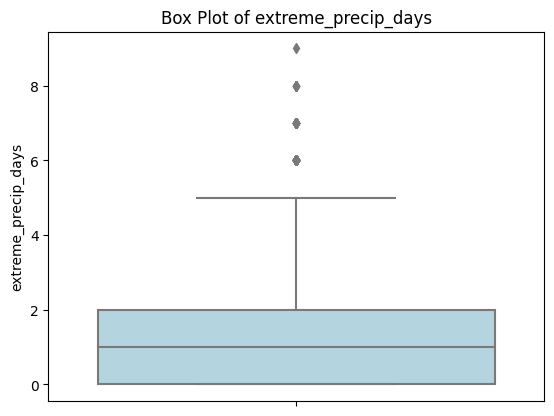

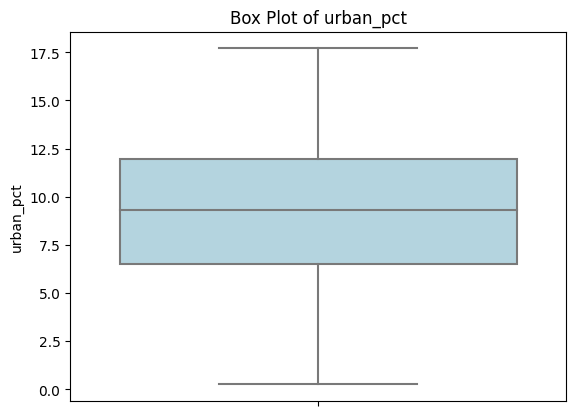

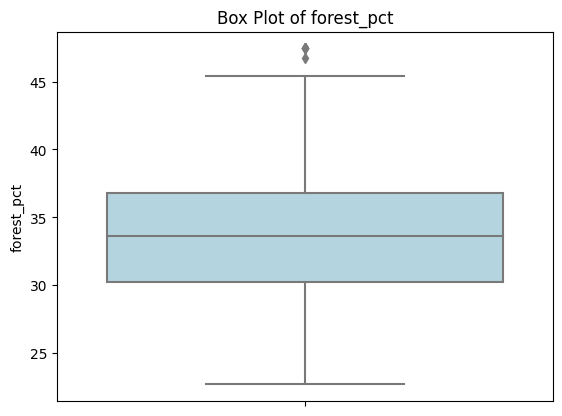

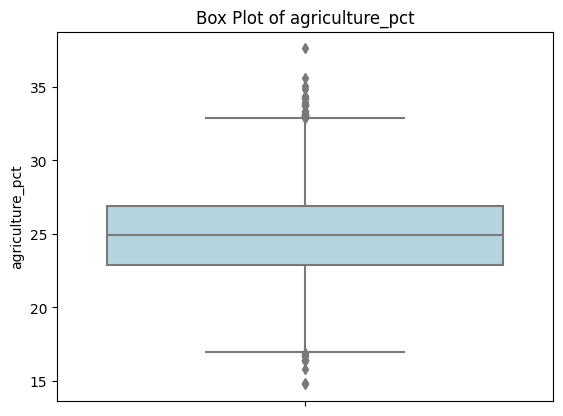

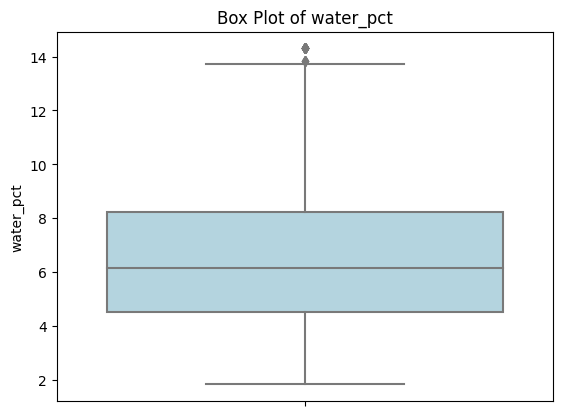

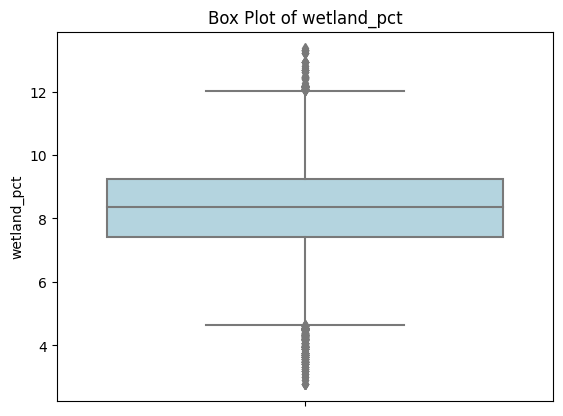

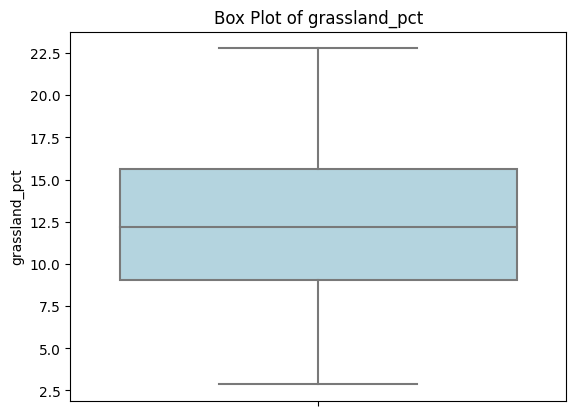

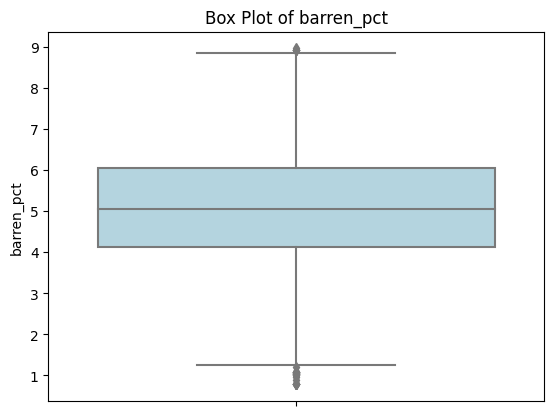

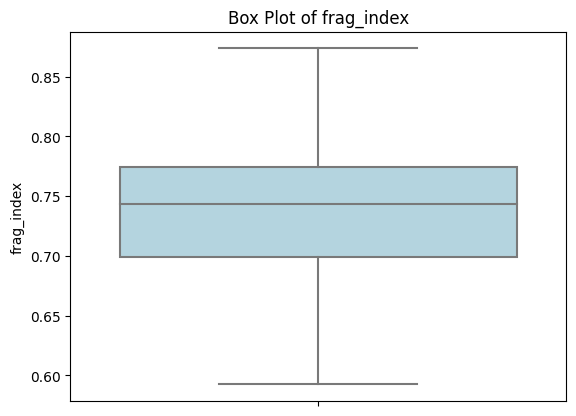

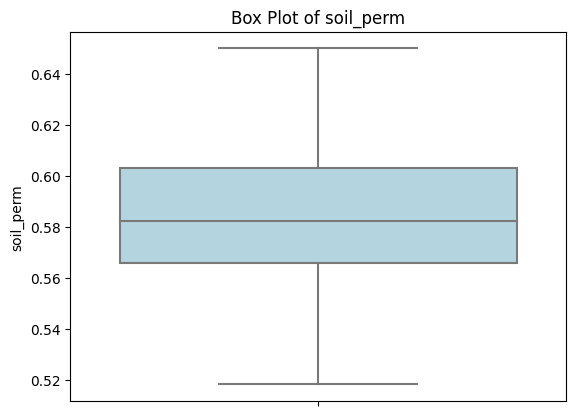

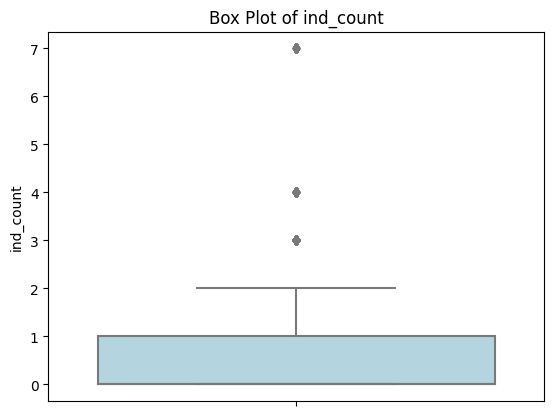

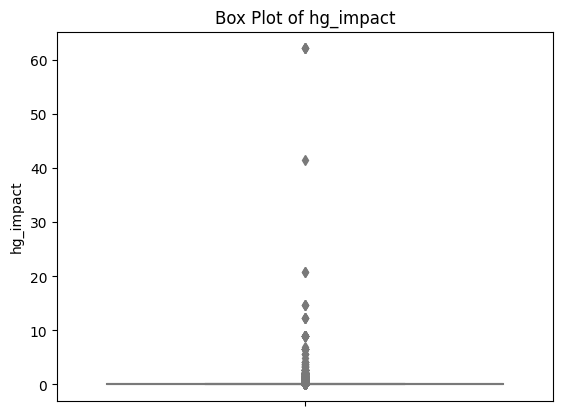

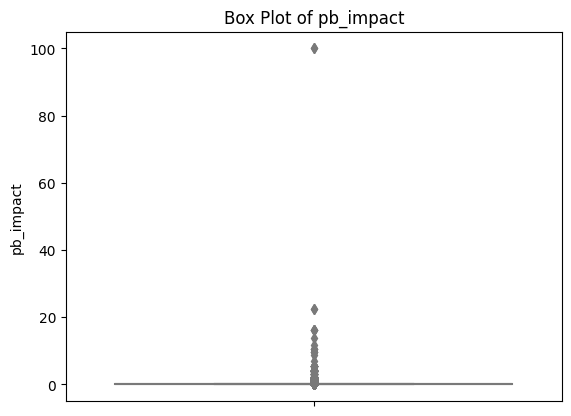

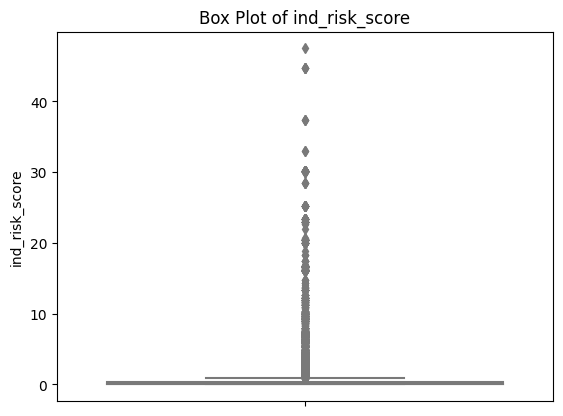

In [18]:
for col in numerical:
    sns.boxplot(y=train[col], color='lightblue')  
    plt.title(f'Box Plot of {col}')
    plt.show()

## Skewness Analysis

In [19]:
for col in X.select_dtypes(exclude='object').columns:
    if X[col].isnull().any():
        skew_value = skew(X[col].dropna())
        if abs(skew_value) < 0.5:
            print(f"{col}: MEAN (skew = {skew_value:.2f})")
        else:
            print(f"{col}: MEDIAN (skew = {skew_value:.2f})")

Latitude: MEAN (skew = -0.47)
Longitude: MEAN (skew = 0.18)
Depth: MEDIAN (skew = 46.31)
temperature_avg: MEAN (skew = -0.05)
rainfall_mm: MEAN (skew = 0.35)
humidity_pct: MEAN (skew = -0.10)
pressure_hPa: MEAN (skew = -0.03)
drought_index: MEAN (skew = -0.00)
extreme_precip_days: MEDIAN (skew = 1.21)
urban_pct: MEAN (skew = -0.11)
forest_pct: MEAN (skew = 0.10)
agriculture_pct: MEAN (skew = 0.03)
water_pct: MEDIAN (skew = 0.68)
wetland_pct: MEAN (skew = -0.30)
grassland_pct: MEAN (skew = 0.07)
barren_pct: MEAN (skew = -0.15)
frag_index: MEAN (skew = -0.21)
soil_perm: MEAN (skew = 0.11)
ind_count: MEDIAN (skew = 3.50)
hg_impact: MEDIAN (skew = 32.95)
pb_impact: MEDIAN (skew = 47.76)
ind_risk_score: MEDIAN (skew = 4.57)


## Numerical Values Correlation Heatmap

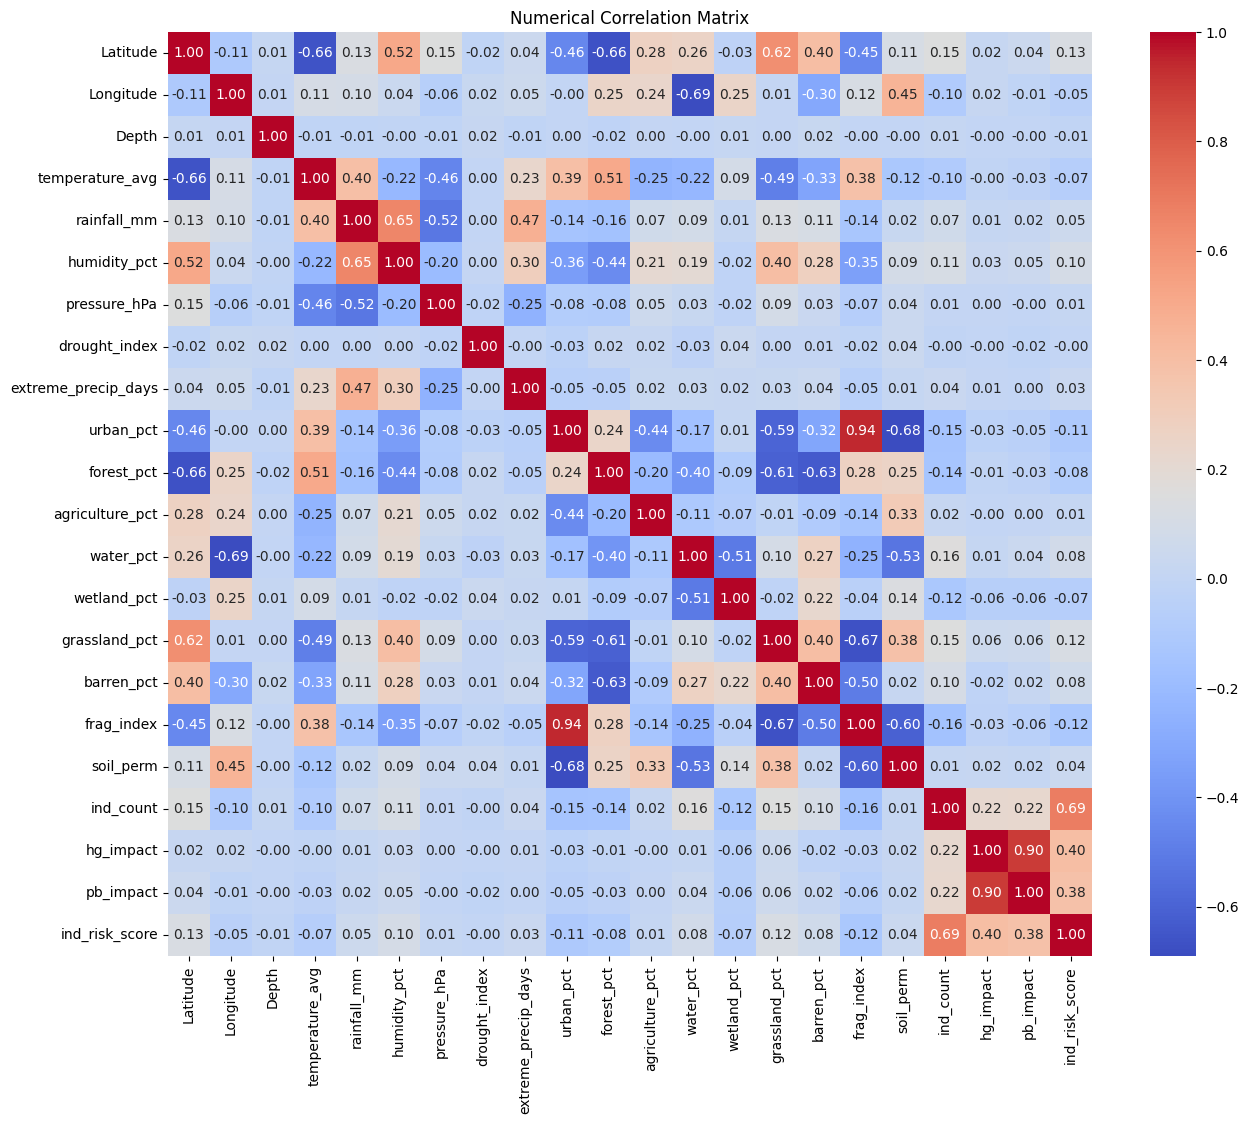

In [20]:
corr_matrix = train.corr(numeric_only=True)

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Numerical Correlation Matrix')
plt.show()

## Categorical Values Correlation Heatmap

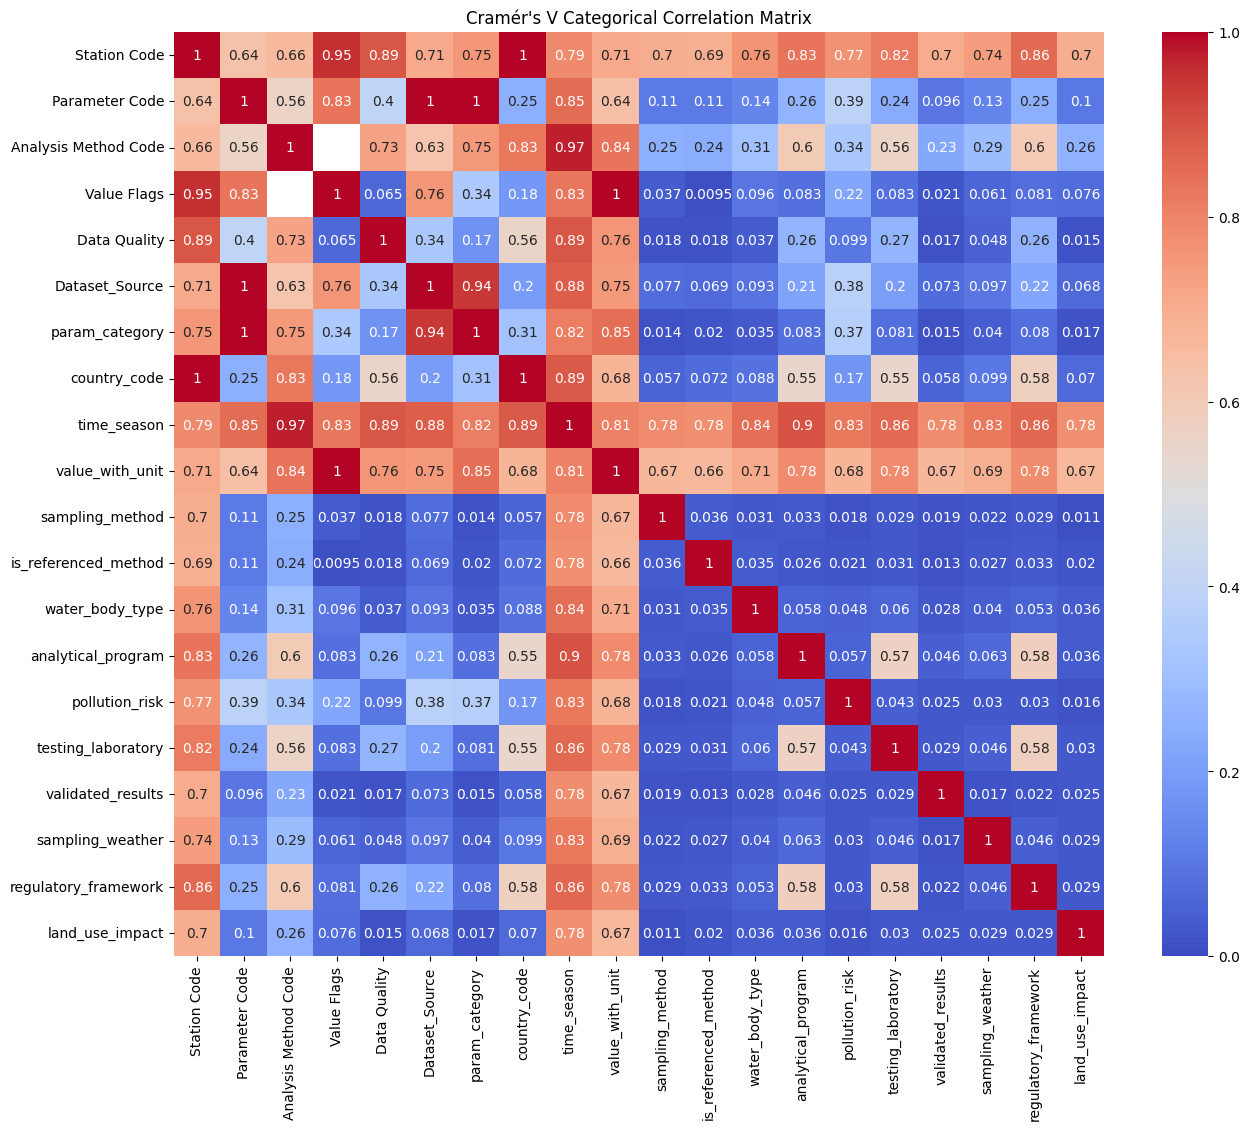

In [21]:
cramer_matrix = pd.DataFrame(np.zeros((len(categorical), len(categorical))), columns=categorical, index=categorical)

for i in range(len(categorical)):
    col_i = categorical[i]
    for j in range(i + 1, len(categorical)):
        col_j = categorical[j]
        table = pd.crosstab(train[col_i], train[col_j])
        assoc_strength = contingency.association(table, method="cramer")
        
        cramer_matrix.loc[col_i, col_j] = assoc_strength
        cramer_matrix.loc[col_j, col_i] = assoc_strength

cramer_matrix = cramer_matrix.replace(0, 1)
plt.figure(figsize=(15, 12))
sns.heatmap(cramer_matrix, annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1)
plt.title("Cramér's V Categorical Correlation Matrix")
plt.show()

## Data Quality (Target) Value Counts

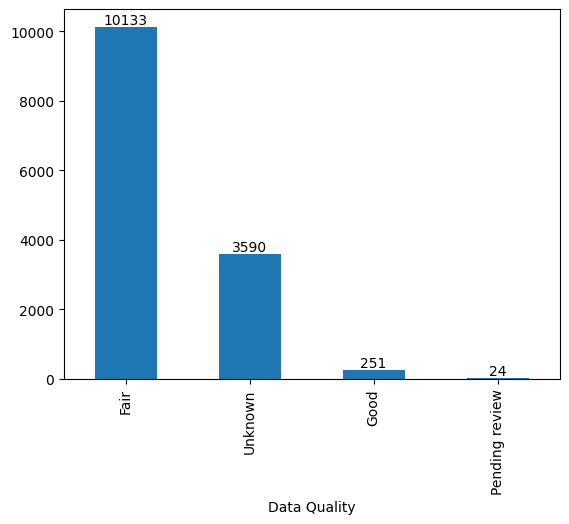

In [22]:
ax = y.value_counts().plot(kind='bar')

for p in ax.patches:
    value = int(p.get_height())
    ax.text(p.get_x() + p.get_width() / 2,
            p.get_height(),
            str(value),
            ha='center',
            va='bottom')
plt.show()

# Preprocessing #1

## Feature Engineering

### time_season -> timestamp, season

In [23]:
X[['timestamp', 'season']] = X['time_season'].str.split(' - ', expand=True)
test[['timestamp', 'season']] = test['time_season'].str.split(' - ', expand=True)

X = X.drop('time_season', axis=1)
test = test.drop('time_season', axis=1)

X[['timestamp', 'season']].head()

,timestamp,season
0,2016-07-06 12:00:00,Summer
1,NaN,NaN
2,2011-07-05 00:00:00,Summer
3,2011-05-10 10:05:00,Spring
4,2005-08-02 10:00:00,Summer


### timestamp -> year, month, day, hour, dayofweek, weekofyear, quarter, is_weekend

In [24]:
X['timestamp'] = pd.to_datetime(X['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

X['year'] = X['timestamp'].dt.year
X['month'] = X['timestamp'].dt.month
X['day'] = X['timestamp'].dt.day
X['hour'] = X['timestamp'].dt.hour
X['dayofweek'] = X['timestamp'].dt.dayofweek
X['weekofyear'] = X['timestamp'].dt.isocalendar().week

test['year'] = test['timestamp'].dt.year
test['month'] = test['timestamp'].dt.month
test['day'] = test['timestamp'].dt.day
test['hour'] = test['timestamp'].dt.hour
test['dayofweek'] = test['timestamp'].dt.dayofweek
test['weekofyear'] = test['timestamp'].dt.isocalendar().week

X = X.drop('timestamp', axis=1)
test = test.drop('timestamp', axis=1)

X[['year', 'month', 'day', 'hour', 'dayofweek', 'weekofyear']] = X[['year', 'month', 'day', 'hour', 'dayofweek', 'weekofyear']].astype('Int64')
test[['year', 'month', 'day', 'hour', 'dayofweek', 'weekofyear']] = test[['year', 'month', 'day', 'hour', 'dayofweek', 'weekofyear']].astype('Int64')

### value_with_unit -> measurement_val, measurement_unit, temp

In [25]:
X[['measurement_val', 'measurement_unit', 'temp']] = X['value_with_unit'].str.split(' ', expand=True)
test[['measurement_val', 'measurement_unit', 'temp']] = test['value_with_unit'].str.split(' ', expand=True)

X = X.drop(['value_with_unit', 'temp'], axis=1)
test = test.drop(['value_with_unit', 'temp'], axis=1)

X['measurement_val'] = X['measurement_val'].astype(float)
test['measurement_val'] = test['measurement_val'].astype(float)

## Feature Transformation

### measurement_val, measurement_unit

In [26]:
conversion_factors = {
    'µg/l': 0.001,
    'ng/l': 0.000001,
    'µS/cm': 1,
    'm³/s': 1,
}

X['measurement_val'] = X.apply(lambda row: row['measurement_val'] * conversion_factors.get(row['measurement_unit'], 1), axis=1)
test['measurement_val'] = test.apply(lambda row: row['measurement_val'] * conversion_factors.get(row['measurement_unit'], 1), axis=1)

X['measurement_unit'] = X['measurement_unit'].replace(list(conversion_factors.keys()), 'mg/l')
test['measurement_unit'] = test['measurement_unit'].replace(list(conversion_factors.keys()), 'mg/l')

## Impute Missing Values Using Other Column(s)

### USING country_code IMPUTE Station Code

In [27]:
X['country_code'] = X['country_code'].fillna(X['Station Code'].str[:3])
test['country_code'] = test['country_code'].fillna(test['Station Code'].str[:3])

### GROUP BY country_code IMPUTE Station Code

In [28]:
X.loc[(X['Station Code'].isna() & X['country_code'].notna()), 'Station Code'] = X.groupby('country_code')['Station Code'].transform(lambda x: x.fillna(x.dropna().sample(1, random_state=seed).iloc[0] if not x.dropna().empty else None))

train_impute_data = X.groupby('country_code')['Station Code'].apply(lambda x: x.fillna(x.dropna().sample(1, random_state=seed).iloc[0] if not x.dropna().empty else None)).reset_index()

train_impute_data = train_impute_data.groupby('country_code').first().reset_index()

test = test.merge(train_impute_data, on='country_code', how='left', suffixes=('', '_train_data'))

test.loc[test['country_code'].notna(), 'Station Code'] = test['Station Code'].fillna(test['Station Code_train_data'])

test.drop(columns=['Station Code_train_data', 'level_1'], inplace=True)

### GROUP BY Station Code IMPUTE Latitude, Longitude, Depth

In [29]:
X.loc[X['Station Code'].notna(), 'Latitude'] = X.groupby('Station Code')['Latitude'].transform(lambda x: x.fillna(x.median()) if x.name is not None else x)
X.loc[X['Station Code'].notna(), 'Longitude'] = X.groupby('Station Code')['Longitude'].transform(lambda x: x.fillna(x.median()) if x.name is not None else x)
X.loc[X['Station Code'].notna(), 'Depth'] = X.groupby('Station Code')['Depth'].transform(lambda x: x.fillna(x.median()) if x.name is not None else x)

train_impute_data = X.groupby('Station Code')[['Latitude', 'Longitude', 'Depth']].median()

test = test.merge(train_impute_data, on='Station Code', how='left', suffixes=('', '_train_data'))

test.loc[test['Station Code'].notna(), 'Latitude'] = test['Latitude'].fillna(test['Latitude_train_data'])
test.loc[test['Station Code'].notna(), 'Longitude'] = test['Longitude'].fillna(test['Longitude_train_data'])
test.loc[test['Station Code'].notna(), 'Depth'] = test['Depth'].fillna(test['Depth_train_data'])

test.drop(columns=['Latitude_train_data', 'Longitude_train_data', 'Depth_train_data'], inplace=True)

### GROUP BY Station Code IMPUTE temperature_avg, rainfall_mm, humidity_pct, pressure_hPa, drought_index, extreme_precip_days

In [30]:
X.loc[X['Station Code'].notna(), 'temperature_avg'] = X.groupby('Station Code')['temperature_avg'].transform(lambda x: x.fillna(x.median()) if x.name is not None else x)
X.loc[X['Station Code'].notna(), 'rainfall_mm'] = X.groupby('Station Code')['rainfall_mm'].transform(lambda x: x.fillna(x.median()) if x.name is not None else x)
X.loc[X['Station Code'].notna(), 'humidity_pct'] = X.groupby('Station Code')['humidity_pct'].transform(lambda x: x.fillna(x.median()) if x.name is not None else x)
X.loc[X['Station Code'].notna(), 'pressure_hPa'] = X.groupby('Station Code')['pressure_hPa'].transform(lambda x: x.fillna(x.median()) if x.name is not None else x)
X.loc[X['Station Code'].notna(), 'drought_index'] = X.groupby('Station Code')['drought_index'].transform(lambda x: x.fillna(x.median()) if x.name is not None else x)
X.loc[X['Station Code'].notna(), 'extreme_precip_days'] = X.groupby('Station Code')['extreme_precip_days'].transform(lambda x: x.fillna(x.median()) if x.name is not None else x)

train_impute_data = X.groupby('Station Code')[['temperature_avg', 'rainfall_mm', 'humidity_pct', 'pressure_hPa', 'drought_index', 'extreme_precip_days']].median()

test = test.merge(train_impute_data, on='Station Code', how='left', suffixes=('', '_train_data'))

test.loc[test['Station Code'].notna(), 'temperature_avg'] = test['temperature_avg'].fillna(test['temperature_avg_train_data'])
test.loc[test['Station Code'].notna(), 'rainfall_mm'] = test['rainfall_mm'].fillna(test['rainfall_mm_train_data'])
test.loc[test['Station Code'].notna(), 'humidity_pct'] = test['humidity_pct'].fillna(test['humidity_pct_train_data'])
test.loc[test['Station Code'].notna(), 'pressure_hPa'] = test['pressure_hPa'].fillna(test['pressure_hPa_train_data'])
test.loc[test['Station Code'].notna(), 'drought_index'] = test['drought_index'].fillna(test['drought_index_train_data'])
test.loc[test['Station Code'].notna(), 'extreme_precip_days'] = test['extreme_precip_days'].fillna(test['extreme_precip_days_train_data'])

test.drop(columns=['temperature_avg_train_data', 'rainfall_mm_train_data', 'humidity_pct_train_data', 'pressure_hPa_train_data', 'drought_index_train_data', 'extreme_precip_days_train_data'], inplace=True)

### GROUP BY Station Code IMPUTE urban_pct, forest_pct, agriculture_pct, water_pct, wetland_pct, grassland_pct, barren_pct

In [31]:
X.loc[X['Station Code'].notna(), 'urban_pct'] = X.groupby('Station Code')['urban_pct'].transform(lambda x: x.fillna(x.median()) if x.name is not None else x)
X.loc[X['Station Code'].notna(), 'forest_pct'] = X.groupby('Station Code')['forest_pct'].transform(lambda x: x.fillna(x.median()) if x.name is not None else x)
X.loc[X['Station Code'].notna(), 'agriculture_pct'] = X.groupby('Station Code')['agriculture_pct'].transform(lambda x: x.fillna(x.median()) if x.name is not None else x)
X.loc[X['Station Code'].notna(), 'water_pct'] = X.groupby('Station Code')['water_pct'].transform(lambda x: x.fillna(x.median()) if x.name is not None else x)
X.loc[X['Station Code'].notna(), 'wetland_pct'] = X.groupby('Station Code')['wetland_pct'].transform(lambda x: x.fillna(x.median()) if x.name is not None else x)
X.loc[X['Station Code'].notna(), 'grassland_pct'] = X.groupby('Station Code')['grassland_pct'].transform(lambda x: x.fillna(x.median()) if x.name is not None else x)
X.loc[X['Station Code'].notna(), 'barren_pct'] = X.groupby('Station Code')['barren_pct'].transform(lambda x: x.fillna(x.median()) if x.name is not None else x)

train_impute_data = X.groupby('Station Code')[['urban_pct', 'forest_pct', 'agriculture_pct', 'water_pct', 'wetland_pct', 'grassland_pct', 'barren_pct']].median()

test = test.merge(train_impute_data, on='Station Code', how='left', suffixes=('', '_train_data'))

test.loc[test['Station Code'].notna(), 'urban_pct'] = test['urban_pct'].fillna(test['urban_pct_train_data'])
test.loc[test['Station Code'].notna(), 'forest_pct'] = test['forest_pct'].fillna(test['forest_pct_train_data'])
test.loc[test['Station Code'].notna(), 'agriculture_pct'] = test['agriculture_pct'].fillna(test['agriculture_pct_train_data'])
test.loc[test['Station Code'].notna(), 'water_pct'] = test['water_pct'].fillna(test['water_pct_train_data'])
test.loc[test['Station Code'].notna(), 'wetland_pct'] = test['wetland_pct'].fillna(test['wetland_pct_train_data'])
test.loc[test['Station Code'].notna(), 'grassland_pct'] = test['grassland_pct'].fillna(test['grassland_pct_train_data'])
test.loc[test['Station Code'].notna(), 'barren_pct'] = test['barren_pct'].fillna(test['barren_pct_train_data'])

test.drop(columns=['urban_pct_train_data', 'forest_pct_train_data', 'agriculture_pct_train_data', 'water_pct_train_data', 'wetland_pct_train_data', 'grassland_pct_train_data', 'barren_pct_train_data'], inplace=True)

### GROUP BY Station Code IMPUTE frag_index, soil_perm, ind_count, hg_impact, pb_impact, ind_risk_score

In [32]:
X.loc[X['Station Code'].notna(), 'frag_index'] = X.groupby('Station Code')['frag_index'].transform(lambda x: x.fillna(x.mean()) if x.name is not None else x)
X.loc[X['Station Code'].notna(), 'soil_perm'] = X.groupby('Station Code')['soil_perm'].transform(lambda x: x.fillna(x.mean()) if x.name is not None else x)
X.loc[X['Station Code'].notna(), 'ind_count'] = X.groupby('Station Code')['ind_count'].transform(lambda x: x.fillna(x.mean()) if x.name is not None else x)
X.loc[X['Station Code'].notna(), 'hg_impact'] = X.groupby('Station Code')['hg_impact'].transform(lambda x: x.fillna(x.mean()) if x.name is not None else x)
X.loc[X['Station Code'].notna(), 'pb_impact'] = X.groupby('Station Code')['pb_impact'].transform(lambda x: x.fillna(x.mean()) if x.name is not None else x)
X.loc[X['Station Code'].notna(), 'ind_risk_score'] = X.groupby('Station Code')['ind_risk_score'].transform(lambda x: x.fillna(x.mean()) if x.name is not None else x)

train_impute_data = X.groupby('Station Code')[['frag_index', 'soil_perm', 'ind_count', 'hg_impact', 'pb_impact', 'ind_risk_score']].mean()

test = test.merge(train_impute_data, on='Station Code', how='left', suffixes=('', '_train_data'))

test.loc[test['Station Code'].notna(), 'frag_index'] = test['frag_index'].fillna(test['frag_index_train_data'])
test.loc[test['Station Code'].notna(), 'soil_perm'] = test['soil_perm'].fillna(test['soil_perm_train_data'])
test.loc[test['Station Code'].notna(), 'ind_count'] = test['ind_count'].fillna(test['ind_count_train_data'])
test.loc[test['Station Code'].notna(), 'hg_impact'] = test['hg_impact'].fillna(test['hg_impact_train_data'])
test.loc[test['Station Code'].notna(), 'pb_impact'] = test['pb_impact'].fillna(test['pb_impact_train_data'])
test.loc[test['Station Code'].notna(), 'ind_risk_score'] = test['ind_risk_score'].fillna(test['ind_risk_score_train_data'])

test.drop(columns=['frag_index_train_data', 'soil_perm_train_data', 'ind_count_train_data', 'hg_impact_train_data', 'pb_impact_train_data', 'ind_risk_score_train_data'], inplace=True)

### GROUP BY param_category IMPUTE Parameter Code

In [33]:
X.loc[X['param_category'].notna(), 'Parameter Code'] = X.groupby('param_category')['Parameter Code'].transform(lambda x: x.fillna(x.dropna().sample(1, random_state=seed).iloc[0] if not x.dropna().empty else None))

train_impute_data = X.groupby('param_category')['Parameter Code'].apply(lambda x: x.fillna(x.dropna().sample(1, random_state=seed).iloc[0] if not x.dropna().empty else None)).reset_index()

train_impute_data = train_impute_data.groupby('param_category').first().reset_index()

test = test.merge(train_impute_data, on='param_category', how='left', suffixes=('', '_train_data'))

test.loc[test['param_category'].notna(), 'Parameter Code'] = test['Parameter Code'].fillna(test['Parameter Code_train_data'])

test.drop(columns=['Parameter Code_train_data', 'level_1'], inplace=True)

### GROUP BY param_category IMPUTE Dataset_Source

In [34]:
X.loc[X['param_category'].notna(), 'Dataset_Source'] = X.groupby('param_category')['Dataset_Source'].transform(lambda x: x.fillna(x.dropna().sample(1, random_state=seed).iloc[0] if not x.dropna().empty else None))

train_impute_data = X.groupby('param_category')['Dataset_Source'].apply(lambda x: x.fillna(x.dropna().sample(1, random_state=seed).iloc[0] if not x.dropna().empty else None)).reset_index()

train_impute_data = train_impute_data.groupby('param_category').first().reset_index()

test = test.merge(train_impute_data, on='param_category', how='left', suffixes=('', '_train_data'))

test.loc[test['param_category'].notna(), 'Dataset_Source'] = test['Dataset_Source'].fillna(test['Dataset_Source_train_data'])

test.drop(columns=['Dataset_Source_train_data', 'level_1'], inplace=True)

## Convert Columns Datatype

In [35]:
X['Station Code'] = X['Station Code'].str[3:].astype('Int64')
test['Station Code'] = test['Station Code'].str[3:].astype('Int64')

## Drop Features

In [36]:
to_drop = [
    'measurement_unit', 
    'Value Flags'
]

X = X.drop(to_drop, axis=1)
test = test.drop(to_drop, axis=1)

# EDA After Preprocess

## Categorical Value Counts

In [37]:
for col in X.select_dtypes(include='object').columns:
    print(X[col].value_counts())
    print()

Parameter Code
EC         804
Cr-Tot     629
O2-Dis     614
Be-Dis     543
Ca-Dis     541
          ... 
Cs-Ext       2
TIC          2
Ni-Sus       2
CN-Free      2
Br2-Dis      1
Name: count, Length: 121, dtype: int64

Analysis Method Code
VMV_3528           501
VMV_1919           368
VMV_3529           173
APHA3120_B_2005     76
VMV_2841            75
                  ... 
MFT                  1
ISO10301_1997        1
EN1233_1996          1
ISTISAN147_2000      1
VMV_3738             1
Name: count, Length: 136, dtype: int64

Dataset_Source
indicator_organism        2432
arsenic                   1387
chloride                  1075
carbon                     782
iron                       747
dissolved_gas              737
electrical_conductance     490
hardness                   326
nickel                     326
calcium                    322
lead                       312
cadmium                    311
magnesium                  306
chromium                   290
halocarbon       

## Categorical Null Values Plot (After)

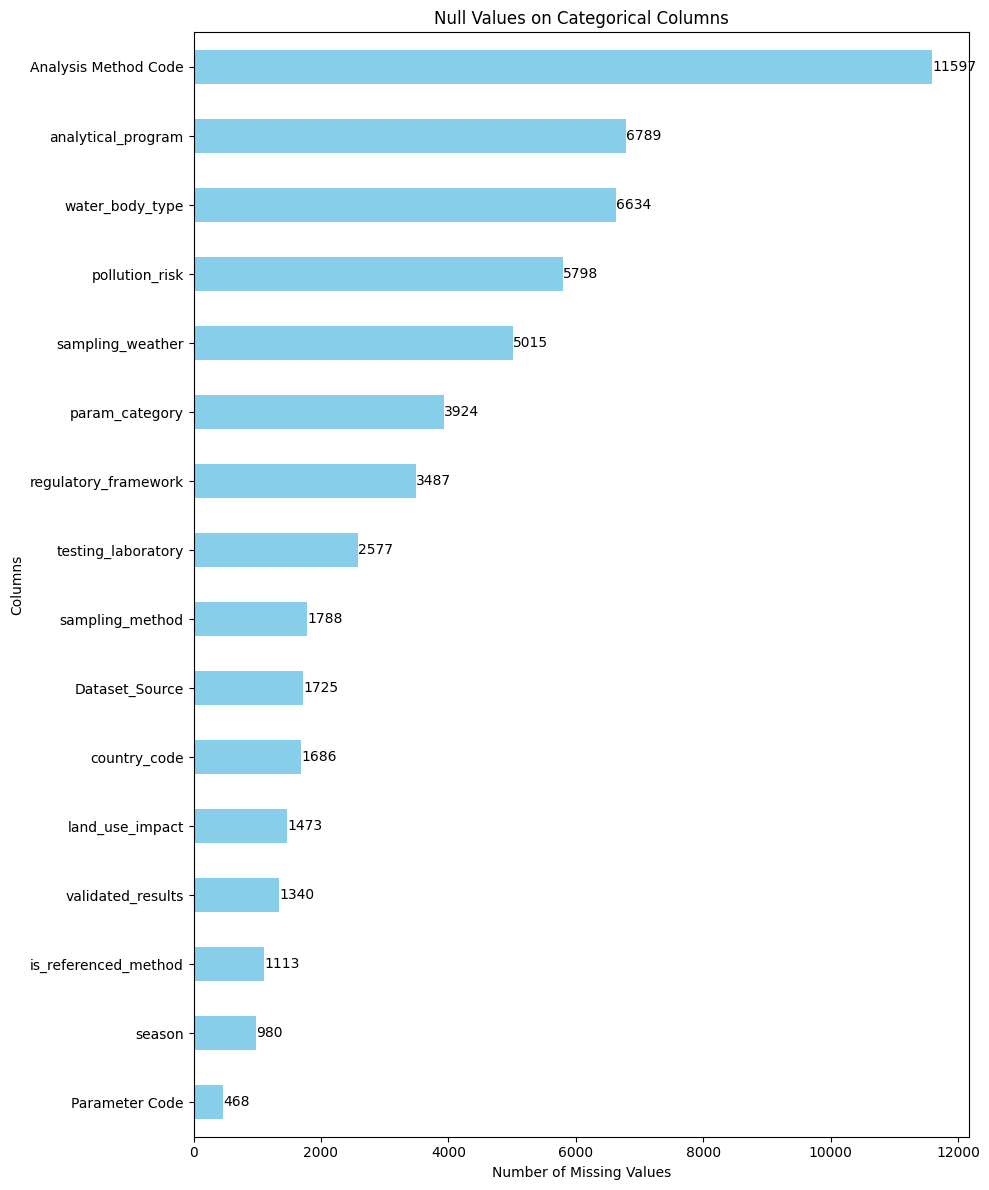

In [38]:
categorical = X.select_dtypes(include='object').columns.tolist()

null_categorical = X[categorical].isnull().sum().sort_values(ascending=True)

plot_null(null_categorical, "Null Values on Categorical Columns")

## Numerical Null Values (After)

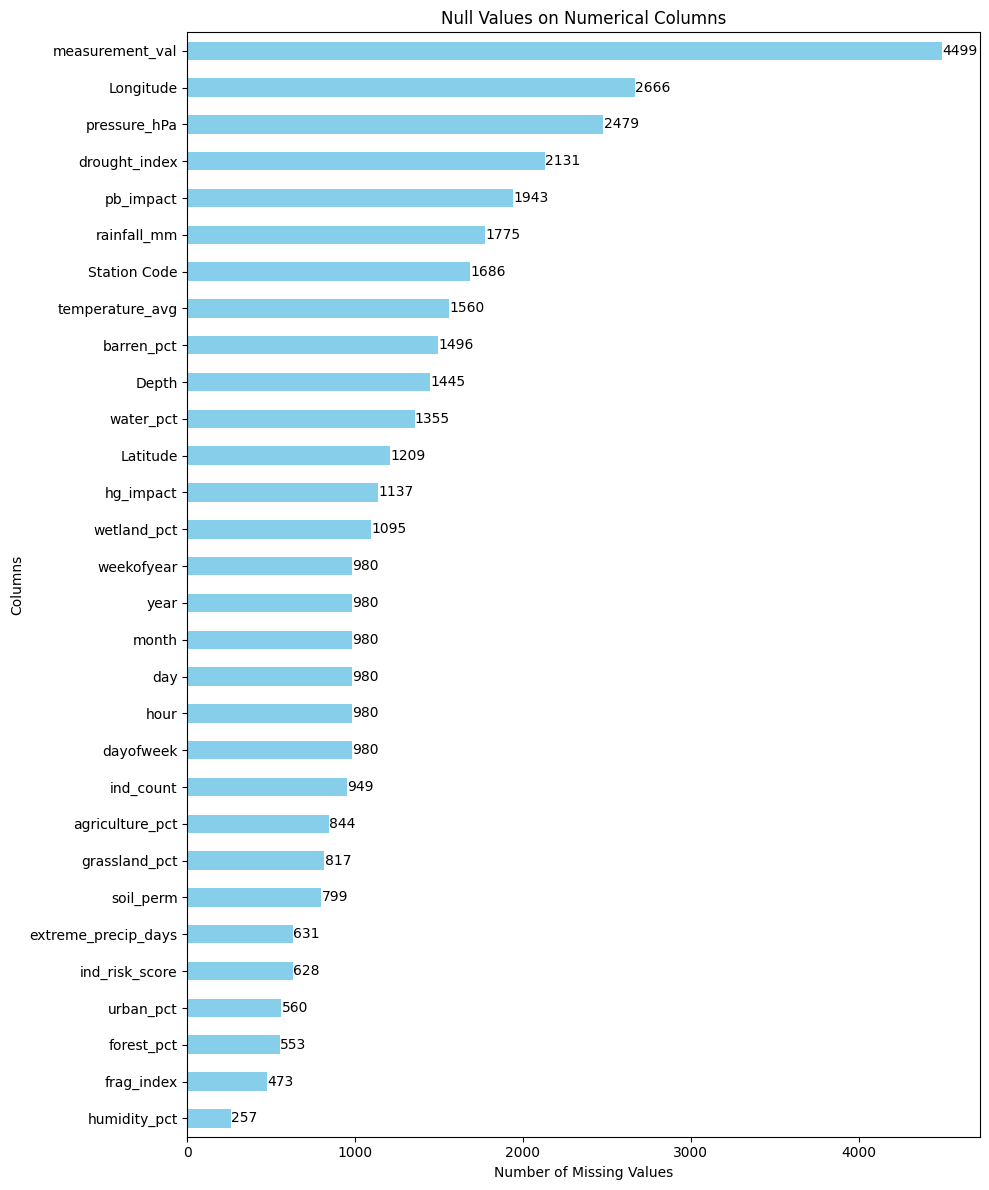

In [39]:
numerical = X.select_dtypes(exclude='object').columns.tolist()

null_numerical = X[numerical].isnull().sum().sort_values(ascending=True)

plot_null(null_numerical, "Null Values on Numerical Columns")

# Preprocessing #2

## Train Test Split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, stratify=y)

## Map Target to Numerical

In [41]:
y_train = y_train.map(target_map)
y_test = y_test.map(target_map)

## Encode Categorical to Numerical

In [42]:
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

for col in X_train.select_dtypes(include='object').columns:
    train_mask = X_train[col].notnull()
    test_mask = X_test[col].notnull()
    X_train.loc[train_mask, col] = encoder.fit_transform(X_train.loc[train_mask, [col]].values.reshape(-1, 1))
    X_test.loc[test_mask, col] = encoder.transform(X_test.loc[test_mask, [col]].values.reshape(-1, 1))

## Impute Missing Values Simultaneously

### Iterative Imputer

In [43]:
imputer = IterativeImputer(random_state=seed)
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

for col in X.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].apply(lambda x: round(x) if not pd.isnull(x) else x)
    X_test[col] = X_test[col].apply(lambda x: round(x) if not pd.isnull(x) else x)

### KNN Imputer

In [44]:
# from sklearn.impute import KNNImputer

# imputer = KNNImputer(n_neighbors=5)
# X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
# X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# for col in X.select_dtypes(include='object').columns:
#     X_train[col] = X_train[col].apply(lambda x: round(x) if not pd.isnull(x) else x)
#     X_test[col] = X_test[col].apply(lambda x: round(x) if not pd.isnull(x) else x)

## Feature Selection

In [45]:
selected = ['Longitude', 'Latitude', 'forest_pct', 'urban_pct', 'measurement_val', 'year', 'Analysis Method Code', 'Station Code', 'grassland_pct', 'country_code']

if selected != []:
    X_train = X_train[selected]
    X_test = X_test[selected]

## Choosing Best Scaler

In [46]:
models = {
    "XGBoost": XGBClassifier(random_state=seed),
    "LightGBM": LGBMClassifier(verbose=-1, random_state=seed),
}

scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

def evaluate_scalers(models, train, y_train, test, y_test):
    for name, model in models.items():
        print(f"{name}:")
        
        best_f1_score = 0
        best_scaler_name = None
        
        for scaler_name, scaler in scalers.items():
            X_train = train.copy()
            X_val = test.copy()

            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
            
            model.fit(X_train, y_train)

            y_pred = model.predict(X_val)
            f1 = f1_score(y_test, y_pred, average='macro')
            print(f"F1 Score with {scaler_name}: {f1:.4f}")
        
            if f1 > best_f1_score:
                best_f1_score = f1
                best_scaler_name = scaler_name
        
        print(f"Best scaler for {name}: {best_scaler_name}\n")

    return best_scaler_name

selected_scaler = evaluate_scalers(models, X_train, y_train, X_test, y_test)

XGBoost:
F1 Score with StandardScaler: 0.6828
F1 Score with MinMaxScaler: 0.6830
F1 Score with RobustScaler: 0.6768
Best scaler for XGBoost: MinMaxScaler

LightGBM:
F1 Score with StandardScaler: 0.6851
F1 Score with MinMaxScaler: 0.6826
F1 Score with RobustScaler: 0.6841
Best scaler for LightGBM: StandardScaler



## Data Scaling

In [47]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## Oversampling

### ADASYN

In [48]:
# from imblearn.over_sampling import ADASYN

# sampler = ADASYN(random_state=seed)
# X_sampled, y_sampled = sampler.fit_resample(X_train, y_train)

### SMOTE

In [49]:
sampler = SMOTE(sampling_strategy='auto', random_state=seed)
X_sampled, y_sampled = sampler.fit_resample(X_train, y_train)

# Model Building & Evaluation

## Macro F1 & Classification Report Function

In [50]:
def train_f1(model):
    print()
    print("Prediction Value Counts : ")
    print(pd.Series(y_pred).replace(target_map.values(), target_map.keys()).value_counts())
    
    print()
    f1Score = f1_score(y_test, y_pred, average='macro')  
    print(f'F1 Score: {f1Score}')

    print()
    print("Classification Report : ")
    print(classification_report(y_test, y_pred))

## KFold & Cross Validation Function

In [51]:
def train_kfold(model):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_macro')
    
    print(f"CV SCORES: {scores}")
    print("Mean CV Score:", np.mean(scores))
    print("Std Deviation:", np.std(scores))

## Feature Importances Function

In [52]:
def plot_importances(model, how_much=20):
    importance = model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importance
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance_df, x='importance', y='feature', palette='viridis')
    plt.title('Top 20 Feature Importances')
    plt.show()

    print(list(feature_importance_df.head(how_much)['feature']))

    return feature_importance_df

## XGBoost Classifier

In [53]:
xgb = XGBClassifier(verbosity=0, random_state=seed)
xgb.fit(X_sampled, y_sampled)

y_pred = xgb.predict(X_test)

train_kfold(xgb)
train_f1(xgb)

CV SCORES: [0.69640847 0.67052588 0.6835784  0.67908039 0.68008381]
Mean CV Score: 0.6819353890567156
Std Deviation: 0.008413393874681782

Prediction Value Counts : 
Fair              2056
Unknown            688
Good                53
Pending review       3
Name: count, dtype: int64

F1 Score: 0.7318412966016409

Classification Report : 
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       718
           1       0.33      0.20      0.25         5
           2       0.70      0.74      0.72        50
           3       0.98      0.99      0.98      2027

    accuracy                           0.98      2800
   macro avg       0.75      0.72      0.73      2800
weighted avg       0.98      0.98      0.98      2800



In [54]:
# # Parameter
# n_splits = 5
# num_classes = 4
# skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

# # Output array
# oof_preds = np.zeros((X_sampled.shape[0], num_classes))
# preds = np.zeros((X_test.shape[0], num_classes))

# for fold, (train_idx, val_idx) in enumerate(skf.split(X_sampled, y_sampled)):
#     print(f"Fold {fold + 1}")

#     X_train, y_train = X_sampled.iloc[train_idx], y_sampled.iloc[train_idx]
#     X_val, y_val = X_sampled.iloc[val_idx], y_sampled.iloc[val_idx]

#     model = XGBClassifier(
#         objective='multi:softprob',  # for probability prediction in multi-class
#         num_class=num_classes,
#         eval_metric='mlogloss',
#         use_label_encoder=False,
#         random_state=seed,
#         n_jobs=-1
#     )

#     model.fit(X_train, y_train)

#     # Predict prob on validation (OOF)
#     oof_preds[val_idx] = model.predict_proba(X_val)

#     # Predict prob on X_test and accumulate
#     preds += model.predict_proba(X_test)

# # Averaging X_test preds
# preds /= n_splits

In [55]:
# pred = np.argmax(preds, axis=1)

# print("Prediction Value Counts : ")
# print(pd.Series(pred).replace(target_map.values(), target_map.keys()).value_counts())
# print()

# print("F1 Score: ")
# print(f1_score(y_test, pred, average='macro'))

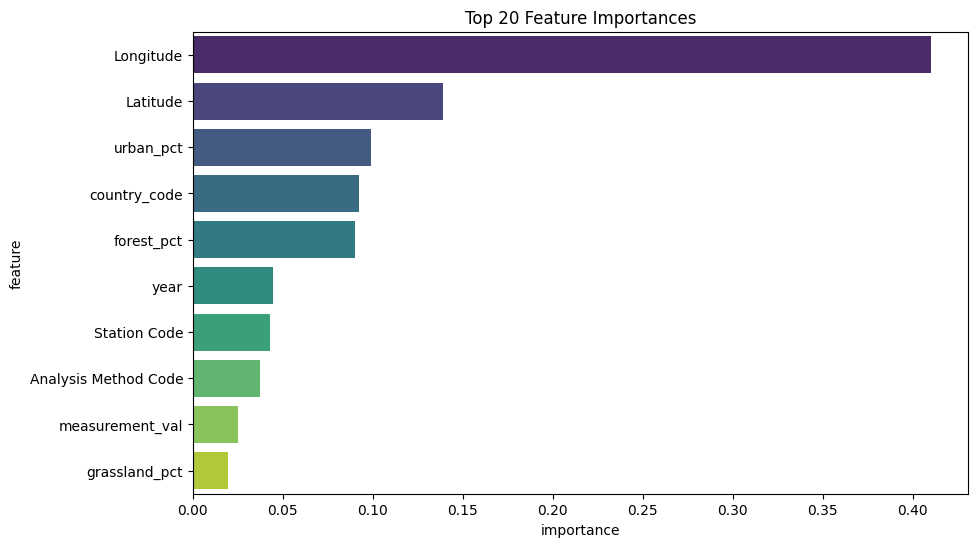

['Longitude', 'Latitude', 'urban_pct', 'country_code', 'forest_pct', 'year', 'Station Code', 'Analysis Method Code', 'measurement_val', 'grassland_pct']


In [56]:
top_feat_xgb = plot_importances(xgb, 10)

10 Most Important Features SHAP : ['Latitude', 'Longitude', 'forest_pct', 'year', 'urban_pct', 'grassland_pct', 'Station Code', 'Analysis Method Code', 'measurement_val', 'country_code']


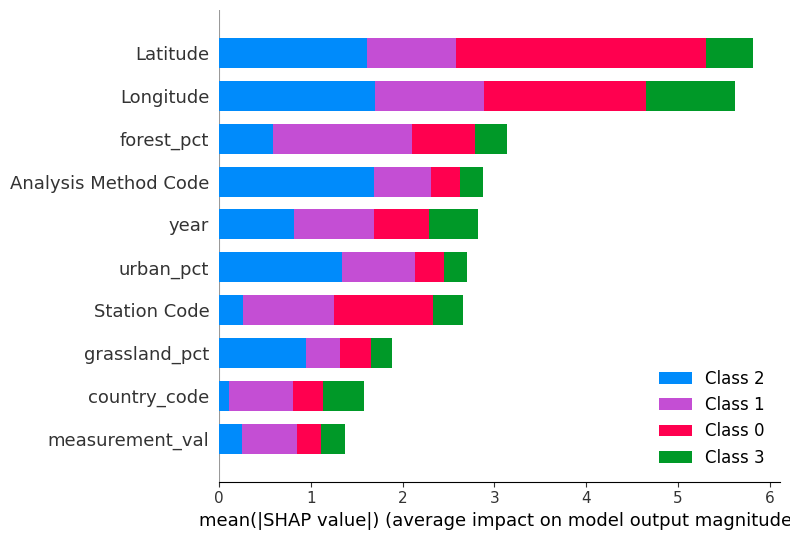

In [57]:
X_obs = pd.DataFrame(X_test, columns=X_train.columns)

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_obs)
mean_shap_values = np.abs(shap_values).mean(axis=0)

top_10_features_idx = np.argsort(mean_shap_values).flatten()[-10:][::-1]

top_10_features = X_obs.columns[top_10_features_idx]

print("10 Most Important Features SHAP :", list(top_10_features))

shap.summary_plot(shap_values, X_obs, feature_names=X_obs.columns, max_display=X_obs.shape[1])

## LGBM Classifier

In [58]:
lgb = LGBMClassifier(verbose=-1, random_state=seed)
lgb.fit(X_sampled, y_sampled)

y_pred = lgb.predict(X_test)

train_kfold(lgb)
train_f1(lgb)

CV SCORES: [0.80388211 0.67932225 0.68645069 0.68501967 0.67968269]
Mean CV Score: 0.7068714841402821
Std Deviation: 0.04858757749613562

Prediction Value Counts : 
Fair              2058
Unknown            688
Good                50
Pending review       4
Name: count, dtype: int64

F1 Score: 0.7304096691550792

Classification Report : 
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       718
           1       0.25      0.20      0.22         5
           2       0.74      0.74      0.74        50
           3       0.98      0.99      0.98      2027

    accuracy                           0.98      2800
   macro avg       0.74      0.72      0.73      2800
weighted avg       0.98      0.98      0.98      2800



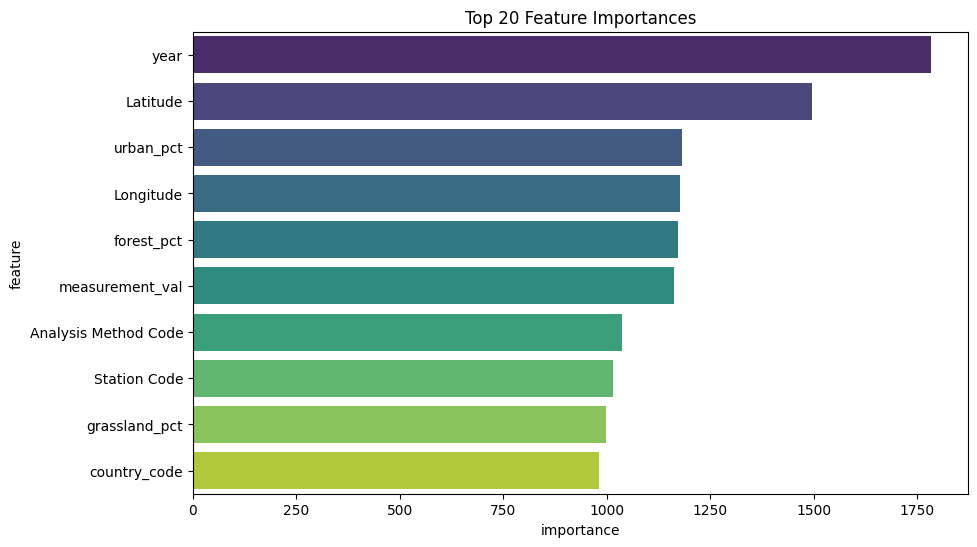

['year', 'Latitude', 'urban_pct', 'Longitude', 'forest_pct', 'measurement_val', 'Analysis Method Code', 'Station Code', 'grassland_pct', 'country_code']


In [59]:
top_feat_lgb = plot_importances(lgb, 10)

10 Most Important Features SHAP : ['Latitude', 'Longitude', 'year', 'forest_pct', 'Station Code', 'Analysis Method Code', 'measurement_val', 'grassland_pct', 'country_code', 'urban_pct']


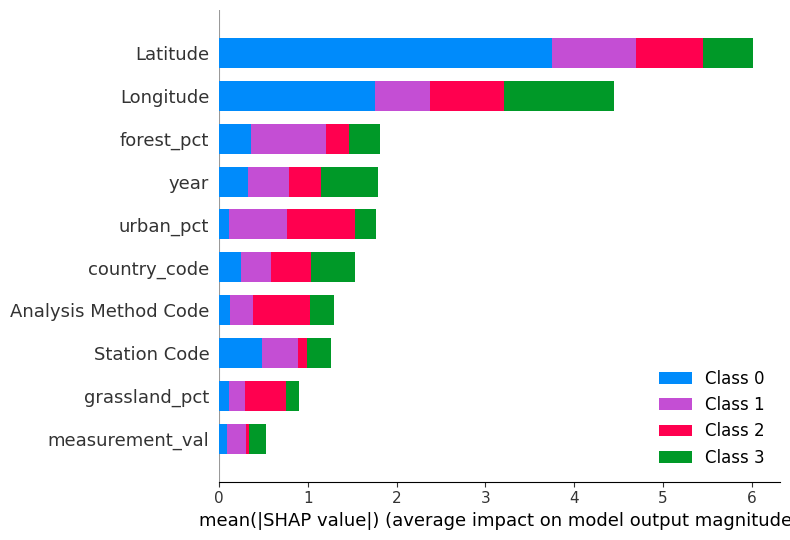

In [60]:
X_obs = pd.DataFrame(X_test, columns=X_train.columns)

explainer = shap.TreeExplainer(lgb)
shap_values = explainer.shap_values(X_obs)
mean_shap_values = np.abs(shap_values).mean(axis=0)

top_10_features_idx = np.argsort(mean_shap_values).flatten()[-10:][::-1]

top_10_features = X_obs.columns[top_10_features_idx]

print("10 Most Important Features SHAP :", list(top_10_features))

shap.summary_plot(shap_values, X_obs, feature_names=X_obs.columns, max_display=X_obs.shape[1])

# Model Tuning / Hyperparameter Optimization

## XGBoost Tuning

In [61]:
# import optuna
# from tqdm.notebook import tqdm

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# def objective_xgb(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 3, 12),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'gamma': trial.suggest_float('gamma', 0, 5),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
#         'use_label_encoder': False,
#         'eval_metric': 'mlogloss', 
#         'objective': 'multi:softmax',
#         'num_class': len(set(y_train))  
#     }

#     model = XGBClassifier(**params)
#     model.fit(X_sampled, y_sampled)

#     y_pred = model.predict(X_test)
#     f1 = f1_score(y_test, y_pred, average='macro')

#     print(f"[Trial {trial.number}] AUC: {f1:.4f} with {params}")
#     return f1

In [62]:
# study_xgb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=seed))
# study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)

# print("Best F1:", study_xgb.best_value)
# print("Best params:", study_xgb.best_params)

## Tuned XGBoost Evaluation

In [63]:
# best_model_xgb = XGBClassifier(**study_xgb.best_params, verbose=-1)

# best_model_xgb.fit(X_train, y_train)
# y_pred = best_model_xgb.predict(X_test)

# train_kfold(best_model_xgb)
# train_f1(best_model_xgb)

In [64]:
# top_feat_xgb = plot_importances(best_model_xgb, 10)

## LGBM Tuning

In [65]:
# import optuna
# from tqdm.notebook import tqdm

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# def objective_lgb(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 16, 512),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
#         'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
#         'random_state': seed
#     }

#     model = LGBMClassifier(**params, verbose=-1)
#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_test)
#     f1 = f1_score(y_test, y_pred, average='macro')

#     print(f"[Trial {trial.number}] AUC: {f1:.4f} with {params}")
#     return f1

In [66]:
# study_lgb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=seed))
# study_lgb.optimize(objective_lgb, n_trials=50, show_progress_bar=True)

# print("Best F1:", study_lgb.best_value)
# print("Best params:", study_lgb.best_params)

## Tuned LGBM Evaluation

In [67]:
# best_model_lgb = LGBMClassifier(**study_lgb.best_params, verbose=-1)

# best_model_lgb.fit(X_train, y_train)
# y_pred = best_model_lgb.predict(X_test)

# train_kfold(best_model_lgb)
# train_f1(best_model_lgb)

In [68]:
# top_feat_lgb = plot_importances(best_model_lgb, 10)

# Preprocessing #3 (Main Train Test)

## Encode Categorical to Numerical (Main)

In [69]:
for col in X.select_dtypes(include='object').columns:
    train_mask = X[col].notnull()
    test_mask = test[col].notnull()
    X.loc[train_mask, col] = encoder.fit_transform(X.loc[train_mask, [col]].values.reshape(-1, 1))
    test.loc[test_mask, col] = encoder.transform(test.loc[test_mask, [col]].values.reshape(-1, 1))

## Impute Missing Values Simultaneously (Main)

In [70]:
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
test = pd.DataFrame(imputer.transform(test), columns=test.columns)

for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].apply(lambda x: round(x) if not pd.isnull(x) else x)
    test[col] = test[col].apply(lambda x: round(x) if not pd.isnull(x) else x)

## Feature Selection (Main)

In [71]:
if selected != []:
    X = X[selected]
    test = test[selected]

## Data Scaling (Main)

In [72]:
X = scaler.fit_transform(X)
test = scaler.transform(test)

## Oversampling (Main)

In [73]:
X, y = sampler.fit_resample(X, y)

y = y.map(target_map)

### OOF (Out Of Folds)

In [74]:
# # Parameter
# n_splits = 5
# num_classes = 4
# skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

# # Output array
# oof_preds = np.zeros((X.shape[0], num_classes))
# test_preds = np.zeros((test.shape[0], num_classes))

# for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
#     print(f"Fold {fold + 1}")

#     X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
#     X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

#     model = XGBClassifier(
#         objective='multi:softprob',  # for probability prediction in multi-class
#         num_class=num_classes,
#         eval_metric='mlogloss',
#         use_label_encoder=False,
#         random_state=seed,
#         n_jobs=-1
#     )

#     model.fit(X_train, y_train)

#     # Predict prob on validation (OOF)
#     oof_preds[val_idx] = model.predict_proba(X_val)

#     # Predict prob on test and accumulate
#     test_preds += model.predict_proba(test)

# # Averaging test preds
# test_preds /= n_splits

# Model Deployment

## Train Best Model (Base XGB)

In [75]:
model = xgb

model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## Predict Test with Best Model

In [76]:
test_pred = model.predict(test)

test_pred = pd.Series(test_pred).replace(target_map.values(), target_map.keys())

print(test_pred.value_counts())

Fair              4390
Unknown           1483
Good               113
Pending review      14
Name: count, dtype: int64


In [77]:
# test_pred = np.argmax(test_preds, axis=1)

# test_pred = pd.Series(test_pred).replace(target_map.values(), target_map.keys())

# print(test_pred.value_counts())

## Submission

In [78]:
submission['Data Quality'] = test_pred

submission.head()

,id,Data Quality
0,0,Fair
1,1,Fair
2,2,Fair
3,3,Unknown
4,4,Unknown


In [80]:
submission.to_csv('SUBMISSION.csv', index=False)

# Import Model

In [83]:
with open('xgbc.pkl','wb') as f:
    pickle.dump(model,f)